In [1]:
import tensorflow as tf  
print(tf.__version__)
import keras
print(keras.__version__)

2.6.2
2.6.0


In [2]:
from keras.layers import Input, Dense,Conv3D, TimeDistributed, Layer, AveragePooling3D, Reshape
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import time

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

### 1. Prepare training permeability maps

#### 1.1 Load channel facies models

In [12]:
Filepath = '/scratch/users/suihong/FlowSimulation/Datasets/SynthesizedChannelsLabels/2D_AllPro_Gslib_fromPetrel(version4)' 

In [13]:
allele=[]  
# stores all facies code values of the file. includes 64x64 lists, and each list includes code values of all realizations at each pixel.

with open (Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:    # filter the lines with property name "Facies unit1 scale1"        
            allele.append(eles)
            
rlz_no = len(allele[0]) # number of realizations


In [14]:
partimgs = np.array(allele, dtype = float).reshape((64, 64, rlz_no)).astype(int)
partimgs = np.where(partimgs == 1, 4, partimgs)/2 * 127.5 # originally, 1 for channel sand facies, and 2 for channel bank; here exchange their codes.
allimgs = np.concatenate((partimgs, partimgs[::-1,:,:]),2)  # partimgs[::-1,:,:] to reverse partimgs vertically: original partimgs 
allimgs = np.transpose(allimgs, (2, 0, 1))  # transpose into (?, 64, 64) dimension
allimgs = allimgs.reshape(-1, 1, 64, 64)

In [15]:
print(allimgs.shape)

(35640, 1, 64, 64)


In [16]:
# randomize the order of images
randseq=np.random.RandomState(232).permutation(allimgs.shape[0])
allimgs = allimgs[randseq]/125.5-1

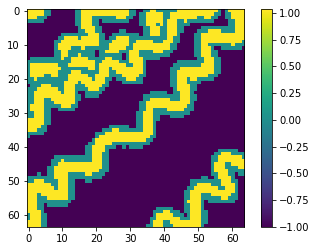

In [17]:
kk = 4805

plt.imshow(allimgs[kk,0])
plt.colorbar()

##### 1.2 Generate permeability maps from the loaded facies models

###### (1) original 64x64 permeability maps

In [18]:
np.random.seed(0)

facies_models_num = allimgs.shape[0]

perm_channel_center = np.random.uniform(1000,4000,facies_models_num)
perm_channel_bank = perm_channel_center * np.random.uniform(0.6,0.85,facies_models_num)
perm_mud = np.random.uniform(5,40,facies_models_num)

for i in range(facies_models_num):
    allimgs[i:i+1] = np.where(allimgs[i:i+1]>=0.75, perm_channel_center[i], allimgs[i:i+1])
    allimgs[i:i+1] = np.where((allimgs[i:i+1]>=-0.75) & (allimgs[i:i+1]<=0.75), perm_channel_bank[i], allimgs[i:i+1])
    allimgs[i:i+1] = np.where(allimgs[i:i+1]<=-0.75, perm_mud[i], allimgs[i:i+1])

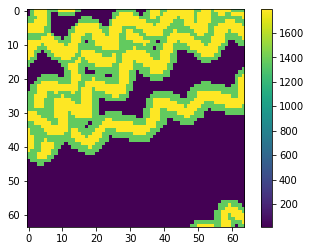

In [19]:
plt.imshow(allimgs[30,0,:,:])
plt.colorbar()

In [20]:
perm_no = 35000

perm_train_64 = allimgs[:perm_no]
print(perm_train_64.shape)

(35000, 1, 64, 64)


###### (2) obtain 32x32 to 8x8 permeability maps by downsampling the original 64x64 perm maps

In [ ]:
from scipy import stats
perm_train_32 = np.zeros([perm_no, 1, 32, 32], dtype=np.float32)
perm_train_16 = np.zeros([perm_no, 1, 16, 16], dtype=np.float32)
perm_train_8 = np.zeros([perm_no, 1, 8, 8], dtype=np.float32)
perm_train_4 = np.zeros([perm_no, 1, 4, 4], dtype=np.float32)

def HighestFrequencyDesampling(real_img):  # dsample real_img by 2
    # used to produce low-D with most frequent facies code
    real_img_t = np.expand_dims(real_img, axis = 3)
    real_img_t_c = np.concatenate((real_img_t[:, 0::2, 0::2], real_img_t[:, 0::2, 1::2], real_img_t[:, 1::2, 0::2], real_img_t[:, 1::2, 1::2]), axis = 3)                
    mode, _ = stats.mode(real_img_t_c, axis = 3)
    real_img = np.squeeze(mode, axis = 3)
    return real_img

def AveragingDesampling(real_img): #Downsample real_img by 2
    # used to produce low-D with averaging method
    real_img = (real_img[:, 0::2, 0::2] + real_img[:, 0::2, 1::2] + real_img[:, 1::2, 0::2] + real_img[:, 1::2, 1::2]) * 0.25
    return real_img    

for idx in range(0, perm_train_64.shape[0]):
    # 32x32 and 16x16 are downsampled using highest frequency method, while 8x8 and 4x4 are obtained using average metho.
    real_img = perm_train_64[idx].astype(np.float32)
    real_img = HighestFrequencyDesampling(real_img) # downsampling into 32x32
    perm_train_32[idx] = real_img
    real_img = HighestFrequencyDesampling(real_img) # downsampling into 16x16
    perm_train_16[idx] = real_img
    
    real_img = AveragingDesampling(real_img) 
    perm_train_8[idx] = real_img    
    real_img = AveragingDesampling(real_img) 
    perm_train_4[idx] = real_img    


In [75]:
perm_train_64 = perm_train_64.astype('float32')
perm_train_32 = perm_train_32.astype('float32')
perm_train_16 = perm_train_16.astype('float32')
perm_train_8  = perm_train_8.astype('float32')
perm_train_4  = perm_train_4.astype('float32')

##### Since Downsampling process takes relatively long time, after downsampling, we save these downsampled data for future use

In [87]:
save_name_64 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_64_orig.txt'
np.savetxt(save_name_64, perm_train_64.reshape(-1, 64), fmt='%i', delimiter=' ', newline='\n')

save_name_32 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_32_highestfreq.txt'
np.savetxt(save_name_32, perm_train_32.reshape(-1, 32), fmt='%i', delimiter=' ', newline='\n')

save_name_16 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_16_highestfreq.txt'
np.savetxt(save_name_16, perm_train_16.reshape(-1, 16), fmt='%i', delimiter=' ', newline='\n')

save_name_8 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_8_av.txt'
np.savetxt(save_name_8, perm_train_8.reshape(-1, 8), fmt='%i', delimiter=' ', newline='\n')

save_name_4 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_4_av.txt'
np.savetxt(save_name_4, perm_train_4.reshape(-1, 4), fmt='%i', delimiter=' ', newline='\n')


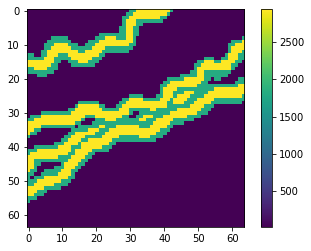

In [78]:
plt.imshow(perm_train_64[5, 0])
plt.colorbar()

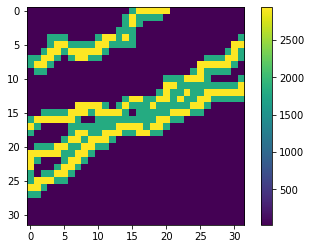

In [79]:
plt.imshow(perm_train_32[5, 0])
plt.colorbar()

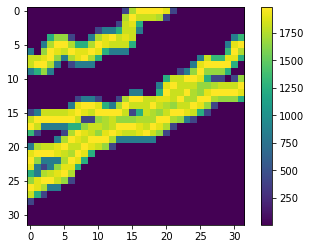

In [80]:
plt.imshow(perm_train_32_highfreq[5, 0])
plt.colorbar()

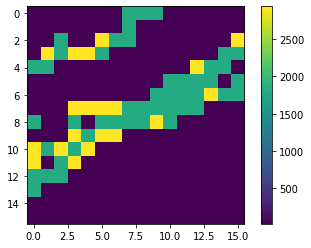

In [81]:
plt.imshow(perm_train_16[5, 0])
plt.colorbar()

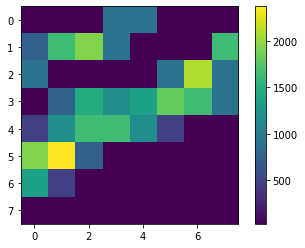

In [82]:
plt.imshow(perm_train_8[5, 0])
plt.colorbar()

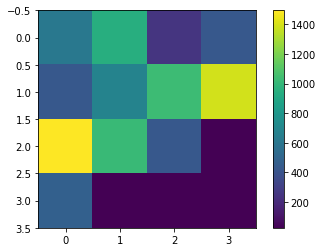

In [83]:
plt.imshow(perm_train_4[5, 0])
plt.colorbar()

##### 1.3 Load previously saved permeability maps (optional)

In [22]:
def import_perm(perm_dir, perm_num):
    saved_perm_path = perm_dir +'permmap_'+str(perm_num)
    with open(saved_perm_path, 'r') as f:
        alist = []
        for line in f:
            if line.startswith('PERMI') or line.startswith('/'):
                continue
            else:
                s = line.strip()
                s = np.array(s.split()).astype(np.float32)
                alist= np.concatenate((alist, s))    
        permarray = alist
        
    return permarray

In [ ]:
test_perm_dir_64 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_64_orig.txt'
perm_train_64 = np.loadtxt(test_perm_dir_64, dtype='int', delimiter= ' ').reshape(-1, 1, 64, 64)
print(perm_train_64.shape)

test_perm_dir_32 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_32_highestfreq.txt'
perm_train_32 = np.loadtxt(test_perm_dir_32, dtype='int', delimiter= ' ').reshape(-1, 1, 32, 32)
print(perm_train_32.shape)

test_perm_dir_16 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_16_highestfreq.txt'
perm_train_16 = np.loadtxt(test_perm_dir_16, dtype='int', delimiter= ' ').reshape(-1, 1, 16, 16)
print(perm_train_16.shape)

test_perm_dir_8 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_8_av.txt'
perm_train_8 = np.loadtxt(test_perm_dir_8, dtype='int', delimiter= ' ').reshape(-1, 1, 8, 8)
print(perm_train_8.shape)

test_perm_dir_4 = '/scratch/users/suihong/MutiGrid_2D/TrainingPermMaps/train_perm_4_av.txt'
perm_train_4 = np.loadtxt(test_perm_dir_4, dtype='int', delimiter= ' ').reshape(-1, 1, 4, 4)
print(perm_train_4.shape)

In [81]:
perm_train_64 = perm_train_64.astype('float32')
perm_train_32 = perm_train_32.astype('float32')
perm_train_16 = perm_train_16.astype('float32')
perm_train_8  = perm_train_8.astype('float32')
perm_train_4  = perm_train_4.astype('float32')

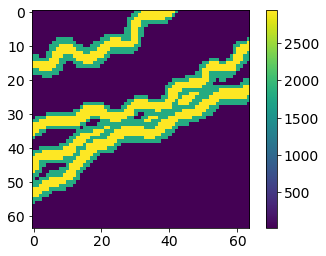

In [82]:
plt.imshow(perm_train_64[5, 0])
plt.colorbar()

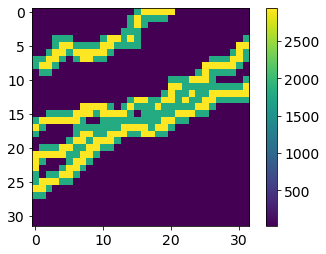

In [83]:
plt.imshow(perm_train_32[5, 0])
plt.colorbar()

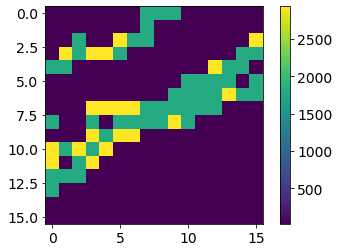

In [84]:
plt.imshow(perm_train_16[5, 0])
plt.colorbar()

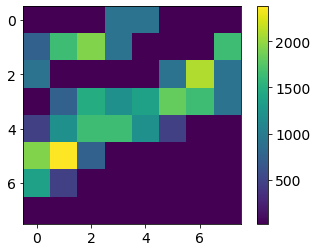

In [85]:
plt.imshow(perm_train_8[5, 0])
plt.colorbar()

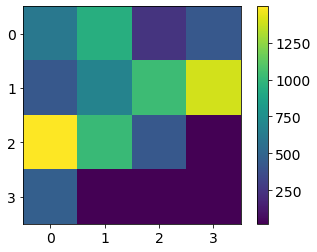

In [86]:
plt.imshow(perm_train_4[5, 0])
plt.colorbar()

### 2 Train multi-grid neural operator

#### (1) Define architectures and losses

In [20]:
import tensorflow as tf

In [19]:
bound_pres_large = 400
bound_pres_small = 200

In [4]:
class RangeConversion(Layer):
    def __init__(self, range_in, range_out): # input and output range
        [self.range_in_sm, self.range_in_lg] = range_in
        [self.range_out_sm, self.range_out_lg] = range_out            
        super(RangeConversion, self).__init__()
    def call(self, parameters):
        parameters_out = (parameters - self.range_in_sm) / (self.range_in_lg - self.range_in_sm) * \
                         (self.range_out_lg - self.range_out_sm) + self.range_out_sm
        return parameters_out

def CNN_block(x, block_lod):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('CNN_%d' % block_pixel):
        layer1 = Conv3D(block_pixel/2, kernel_size = 3, padding="same", data_format = 'channels_first', activation='softplus', \
                        kernel_initializer=initializer, bias_initializer= initializer)(x) 
        return layer1                

def DownSamp_block(x, block_lod):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('DownSamp_%d' % block_pixel):
        layer1 = AveragePooling3D(pool_size=(2, 2, 2), strides = (2, 2, 2), padding='valid', data_format= 'channels_first')(x)    
        return layer1       

def UpSamp_block(x, block_lod):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('UpSamp_%d' % block_pixel):
        s = x.shape
        x = tf.reshape(x, [-1, s[1], s[2], 1, s[3], 1, s[4], 1])
        x = tf.tile(x, [1, 1, 1, 2, 1, 2, 1, 2])
        x = tf.reshape(x, [-1, s[1], s[2] * 2, s[3] * 2, s[4] * 2])    
        return x    
    
def Dense_block(x, block_lod):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('Dense_%d' % block_pixel):
        neur_num = x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]
        layer1 = Reshape((neur_num, ))(x)
        layer2 = Dense(neur_num, activation='softplus', kernel_initializer=initializer, bias_initializer= initializer)(layer1) 
        layer3 = Reshape((x.shape[1], x.shape[2], x.shape[3], x.shape[4]))(layer2)
        return layer3      

def Conc_block(x1, x2, block_lod):
    block_pixel = 2**block_lod
    with tf.compat.v1.variable_scope('Conct_%d' % block_pixel):  
        layer1 = tf.concat([x1, x2], axis = 1)
    return layer1
    
initializer = tf.keras.initializers.GlorotNormal()    
def create_CNN_model(type = 'original', time_steps = 16, pixel = 64, initializer = tf.keras.initializers.GlorotNormal()):
    # type: 'original' for original model producing pressure map from perm cube; 
    #       'error' for error model producing pressure error map from (perm cube + residual cube) 
    # pixel: pixel number along one (spatial) axis of input and output 3D cubes, a value from (64, 32, 16, 8)
    # time_step: pixel number along one (temporal) axis of input and output 3D cubes, a value from (16, 8, 4, 2, 1)

    with tf.compat.v1.variable_scope('Preproc'):
        if type == 'original':
            t = Input(shape = (1, time_steps, pixel, pixel), name = 'input')
            x = RangeConversion([0, 4000], [-1, 1])(t)
        elif type == 'error':
            t = Input(shape = (2, time_steps, pixel, pixel), name = 'input')  # channel 0: perm cube; channel 1: residual cube
            x = tf.concat([RangeConversion([0, 4000], [-1, 1])(t[:, 0:1]), t[:, 1:2]], axis = 1, name = 'input_rangeconversion')
     
    with tf.compat.v1.variable_scope('Encoder'):
        res_layers = []
        lod = int(np.log2(pixel))         
        for i in range(lod, 1, -1):  # i from 6 to 2
            if i >= 3:
                x = CNN_block(x, i)
                res_layers.append(x)
                x = DownSamp_block(x, i)
            else:      
                x = Dense_block(x, i)
               
    with tf.compat.v1.variable_scope('Decoder'):
        for i in range(3, lod + 1):
            x = UpSamp_block(x, i)
            x = Conc_block(x, res_layers[2 - i], i)
            x = CNN_block(x, i)
           
        output = Conv3D(1, kernel_size = 3, padding="same", data_format = 'channels_first', activation='linear', \
                        kernel_initializer=initializer, bias_initializer= initializer)(x)  # shape of [N, 1, 16, 64, 64] 
    return Model(t, output)

In [5]:
# calculate residual matrix from pde using finite difference method

def residual_matrix(network_inputs, network_outputs, boundary_strenghten = False, boundary_w = 10):  # network_inputs of shape (N, 1(or 2), 64, 64, 64)   network_outputs of shape (N, 1, 64, 64, 64)    
    type = 'original' if network_inputs.shape[1] == 1 else 'error'
    pixel = network_inputs.shape[-1]
    t_steps = network_inputs.shape[-3]
    
    dt = 1.* (16 / t_steps)
    dx = 50.* (64 / pixel)
    dy = 50.* (64 / pixel)
    miu = 2
    Ct = 1.8*10**(-2)
    unit_trans_para = 8.52702    
   
    if type == 'original':
        bound_sta_value = bound_pres_large
        bound_end_value = bound_pres_small
    elif type == 'error':
        bound_sta_value = 0
        bound_end_value = 0        
        
    bound_sta = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, t_steps, 1, pixel))+bound_sta_value     # shape of (N, 1, 16, 1, 64)
    bound_end = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, t_steps, 1, pixel))+bound_end_value     # shape of (N, 1, 16, 1, 64)
    init_map = tf.zeros(shape = (tf.shape(network_outputs)[0], 1, 1, pixel, pixel+2))+bound_end_value  # shape of (N, 1, 1, 64, 66)
 
    network_outputs = tf.concat([bound_sta, network_outputs[:,:,:,1:-1], bound_end], axis = 3)  # shape of (N, 1, 16, 64, 64) 
    network_outputs = tf.concat([network_outputs[:, :, :, :, :1], network_outputs, network_outputs[:, :, :, :, -1:]], axis = 4) # shape of (N, 1, 16, 64, 66)  
    network_outputs = tf.concat([init_map, network_outputs], axis = 2)  # shape of (N, 1, 17, 64, 66)
    
    perm = network_inputs[:, 0:1]    # shape of (N, 1, 16, 64, 64)
    perm = tf.concat([perm[:, :, :, :, :1], perm, perm[:, :, :, :, -1:]], axis = 4) # shape of (N, 1, 16, 64, 66)  
    perm_east = (2 * perm[:, :, :, 1:-1, 1:-1] * perm[:, :, :, 1:-1, 2: ]) / (perm[:, :, :, 1:-1, 1:-1] + perm[:, :, :, 1:-1, 2: ])  # shape of (N, 1, 16, 62, 64)
    perm_west = (2 * perm[:, :, :, 1:-1, 1:-1] * perm[:, :, :, 1:-1, :-2]) / (perm[:, :, :, 1:-1, 1:-1] + perm[:, :, :, 1:-1, :-2])# shape of (N, 1, 16, 62, 64)
    perm_north = (2 * perm[:, :, :, 1:-1, 1:-1] * perm[:, :, :, :-2, 1:-1]) / (perm[:, :, :, 1:-1, 1:-1] + perm[:, :, :, :-2, 1:-1])# shape of (N, 1, 16, 62, 64)
    perm_south = (2 * perm[:, :, :, 1:-1, 1:-1] * perm[:, :, :, 2: , 1:-1]) / (perm[:, :, :, 1:-1, 1:-1] + perm[:, :, :, 2: , 1:-1])# shape of (N, 1, 16, 62, 64)

    output_deri_x_east = (network_outputs[:, :, 1:, 1:-1, 2:  ] - network_outputs[:, :, 1:, 1:-1, 1:-1]) / dx  # shape of (N, 1, 16, 62, 64)
    output_deri_x_west = (network_outputs[:, :, 1:, 1:-1, 1:-1] - network_outputs[:, :, 1:, 1:-1, :-2]) / dx  # shape of (N, 1, 16, 62, 64)
    output_deri_y_north = (network_outputs[:, :, 1:, 1:-1, 1:-1] - network_outputs[:, :, 1:, :-2 , 1:-1]) / dy  # shape of (N, 1, 16, 62, 64)
    output_deri_y_south = (network_outputs[:, :, 1:, 2:  , 1:-1] - network_outputs[:, :, 1:, 1:-1, 1:-1]) / dy  # shape of (N, 1, 16, 62, 64)    

    network_deri_t = (network_outputs[:, :, 1:, 1:-1, 1:-1] - network_outputs[:, :, :-1, 1:-1, 1:-1]) / dt  # shape of (N, 1, 16, 62, 64)
    
    left_term = unit_trans_para * ((perm_east * output_deri_x_east - perm_west * output_deri_x_west) / dx + \
                                   (perm_south * output_deri_y_south - perm_north * output_deri_y_north) / dy)                                  
    right_term = miu * Ct * network_deri_t  
    pde_matrix = left_term - right_term   # shape of (N, 1, 16, 62, 64)
    if boundary_strenghten:
        weight_matrix = tf.concat([boundary_w * tf.ones([tf.shape(pde_matrix)[0],tf.shape(pde_matrix)[1], 1, tf.shape(pde_matrix)[-1]]), \
                          tf.ones(tf.shape(pde_matrix))[:,:,:, 1:-1],\
                          boundary_w * tf.ones([tf.shape(pde_matrix)[0], tf.shape(pde_matrix)[1], 1, tf.shape(pde_matrix)[-1]])], axis = 3)
        pde_matrix = pde_matrix * weight_matrix   # shape of (N, 1, 16, 62, 64)
    
    if type == 'error':
        res = network_inputs[:, 1:2]  # shape of (N, 1, 16, 64, 64)
        pde_matrix = pde_matrix - res[:, :, :, 1:-1]     # shape of (N, 1, 16, 62, 64)
    
    return pde_matrix  # shape of (N, 1, 16, 62, 64)

import tensorflow_probability as tfp
def pde_loss(network_inputs, network_outputs):  # network_inputs of shape (N, 1(or 2), 16, 64, 64)   network_outputs of shape (N, 1, 64, 64, 64)  
    pde_matrix = residual_matrix(network_inputs, network_outputs)   # shape of (N, 1, 16, 62, 64)
    pde_matrix_sq = pde_matrix**2
    loss_1 = K.sqrt(K.mean(pde_matrix_sq))  # mean square root loss for each cell: sqrt((x1^2 + x2^2 + ... + xn^2)/n);  

    quantile = tfp.stats.percentile(pde_matrix_sq, q = 50, interpolation = 'linear')
    pde_matrix_sq_lg = tf.where(pde_matrix_sq < quantile, 0., pde_matrix_sq)
    loss_2 = K.sqrt(K.mean(pde_matrix_sq_lg))
        
    loss = 0.3 * loss_1 + 0.7 * loss_2
          
    return loss  # shape of (N, )


In [6]:
def residual_downscale(cur_residual):  # shape of cur_residual (N, 1, 16, 64, 64)  
    new_res = (cur_residual[:, :, :-1:2, :-1:2, :-1:2] + cur_residual[:,:, :-1:2, :-1:2, 1::2] + \
               cur_residual[:, :,:-1:2, 1::2, :-1:2] + cur_residual[:, :,:-1:2, 1::2, 1::2] + \
               cur_residual[:, :,1::2, :-1:2, :-1:2] + cur_residual[:, :,1::2, :-1:2, 1::2] + \
               cur_residual[:, :,1::2, 1::2, :-1:2] + cur_residual[:, :,1::2, 1::2, 1::2]) / 8        
    return new_res  # shape of cur_residual (N, 1, 8, 32, 32)


def upscale(cur_cubes):  # shape of cur_cubes (N, 1, 8, 32, 32)
    cube_num = cur_cubes.shape[0]
    cube_ch = cur_cubes.shape[1]
    cube_time = cur_cubes.shape[2]
    cur_pixel = cur_cubes.shape[-1]
    up_cubes = np.zeros((cube_num, cube_ch, cube_time * 2, cur_pixel * 2 - 1, cur_pixel * 2 - 1))
    up_cubes[:, :, 1::2, ::2, ::2] = cur_cubes
    up_cubes[:, :, 2::2] = (up_cubes[:, :, 1:-1:2] + up_cubes[:, :, 3::2]) / 2 
    up_cubes[:, :, 0] = 2 * up_cubes[:, :, 1] - up_cubes[:, :, 2] if cube_time > 1 else up_cubes[:, :, -1]
    up_cubes[:, :, :, 1::2] = (up_cubes[:, :, :, 0:-1:2] + up_cubes[:, :, :, 2::2]) / 2
    up_cubes[:, :, :, :, 1::2] = (up_cubes[:, :, :, :, 0:-1:2] + up_cubes[:, :, :, :, 2::2]) / 2
    up_cubes = np.insert(up_cubes, cur_pixel, 0, axis = 3)
    up_cubes[:, :, :, cur_pixel - 1] = (up_cubes[:, :, :, cur_pixel + 1] - up_cubes[:, :, :, cur_pixel - 2]) / 3 + up_cubes[:, :, :, cur_pixel - 2]
    up_cubes[:, :, :, cur_pixel] = (up_cubes[:, :, :, cur_pixel + 1] - up_cubes[:, :, :, cur_pixel - 2]) / 3 * 2 + up_cubes[:, :, :, cur_pixel - 2]
    up_cubes = np.insert(up_cubes, cur_pixel, 0, axis = 4)
    up_cubes[:, :, :, :, cur_pixel - 1] = (up_cubes[:, :, :, :, cur_pixel + 1] - up_cubes[:, :, :, :, cur_pixel - 2]) / 3 + up_cubes[:, :, :, :, cur_pixel - 2]
    up_cubes[:, :, :, :, cur_pixel] = (up_cubes[:, :, :, :, cur_pixel + 1] - up_cubes[:, :, :, :, cur_pixel - 2]) / 3 * 2 + up_cubes[:, :, :, :, cur_pixel - 2]    
    return up_cubes

def level_NN_train(level, NN_type, perm, residual, train_epoch, batch_size, learning_rate = 1e-4):
    # level: resolution level: 64, 32, 16, 8
    # residual: 3D residual cube with the same resolution as the current lvel or twice of the current level value, e.g., [N, 1, 64, 64, 64] at level = 32
    # perm: 3D permeability cubes with shape of [N, 1, 16, 64, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    train_num = residual.shape[0]
    residual_resolution = residual.shape[-1]
        
    strategy = tf.distribute.MirroredStrategy() #devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"])
    with strategy.scope():
        CNN_model = create_CNN_model(type = NN_type, time_steps = int(level/4), pixel = level)
        optimizer = Adam(lr=learning_rate)
    
    if NN_type == 'error': 
        if residual_resolution == 2 * level: residual = residual_downscale(residual)
        train_inputs = np.concatenate([perm, residual], axis = 1).astype(np.float32)  # shape of [N, 2, 16, 64, 64]
    elif NN_type == 'original':
        train_inputs = perm  # shape of [N, 1, 16, 64, 64]  
    train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs)).batch(batch_size)
    train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    def train_step(input_data):
        NN_inputs = input_data 
        with tf.GradientTape() as tape:
            NN_outputs = CNN_model(NN_inputs, training=True)
            loss = pde_loss(NN_inputs, NN_outputs)  
        gradients = tape.gradient(loss, CNN_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, CNN_model.trainable_variables))
        return loss
    
    @tf.function
    def distributed_train_step(dist_inputs):
        per_replica_losses = strategy.run(train_step, args=(dist_inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        
    for _ in range(train_epoch):
        for dist_inputs in train_dataset:
            distributed_train_step(dist_inputs)

    pred_batch_size = 4000 if level < 64 else 2000 
    pred_dataset = tf.data.Dataset.from_tensor_slices((train_inputs)).batch(pred_batch_size)
    pred_dataset = strategy.experimental_distribute_dataset(pred_dataset)
    
    def pred_step(input_data):
        NN_inputs = input_data 
        NN_outputs = CNN_model(NN_inputs, training=False)  # shape of [N, 1, 16, 64, 64]
        bou_st = bound_pres_large if NN_type == 'original' else 0    
        bou_ed = bound_pres_small if NN_type == 'original' else 0
        
        bou_st_tensor = tf.zeros((NN_outputs.shape[0], NN_outputs.shape[1], NN_outputs.shape[2], 1, NN_outputs.shape[4])) + bou_st
        bou_ed_tensor = tf.zeros((NN_outputs.shape[0], NN_outputs.shape[1], NN_outputs.shape[2], 1, NN_outputs.shape[4])) + bou_ed 
        NN_outputs = tf.concat([bou_st_tensor, NN_outputs[:, :, :, 1:-1], bou_ed_tensor], axis=3)
        residual = residual_matrix(NN_inputs, NN_outputs)  
        return residual 
    
    new_residual = np.zeros((train_inputs.shape[0], 1, int(level/4), level, level))  # of shape [35000, 1, 16, 64, 64]
    i = 0
    for dist_inputs_pred in pred_dataset:
        result = np.concatenate(strategy.run(pred_step, args=(dist_inputs_pred,)).values, axis = 0)
        new_residual[i * pred_batch_size : min((i + 1) * pred_batch_size, train_inputs.shape[0]), :, :, 1:-1] = result
        i = i + 1

    return CNN_model, new_residual

def V_cycle_train(levels, NN_types, perms, train_epochs, batch_size, learning_rate, ini_residual):
    # levels: e.g., [64, 32, 16, 8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
    # perm cubes: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 1, 16, 64, 64]
    # ini_residual: initial residual
    
    level_num = len(levels)
    CNN_models = []

    for i in range(level_num):
        level = levels[i]
        print('training for level:' + str(level))
        NN_type = NN_types[i]
        perm = perms[i]
        if i == 0: residual = ini_residual 
        train_epoch = train_epochs[i]
        CNN_model, new_residual = level_NN_train(level, NN_type, perm, residual, train_epoch, batch_size, learning_rate)  
        CNN_models.append(CNN_model)        
        residual = new_residual
     
    return CNN_models

In [7]:
def level_NN_predict(level, NN, NN_type, perm, residual):
    # level: resolution level: 64, 32, 16, 8
    # residual: 2D residual map with the same resolution as the current lvel or twice of the current level value, e.g., [N, 1, 16, 64, 64] at level = 32
    # perm: 3D permeability maps with shape of [N, 1, 16, 64, 64] and type of 'float32' 
    # NN_type: network type, 'original' or 'error'
    
    num = residual.shape[0]
    residual_resolution = residual.shape[-1] 
    
    if NN_type == 'error': 
        if residual_resolution == 2 * level: residual = residual_downscale(residual)
        NN_inputs = np.concatenate([perm, residual], axis = 1).astype(np.float32) 
        bou_st = 0
        bou_end = 0        
    elif NN_type == 'original':
        NN_inputs = perm
        bou_st = bound_pres_large
        bou_end = bound_pres_small        

    new_residual = np.zeros(perm.shape)  # of shape [N, 1, 16, 64, 64] 
    NN_output = np.zeros(perm.shape)  # of shape [N, 1, 16, 64, 64] 
    print(NN.variables[0].device)  
    NN_output = NN(NN_inputs, training=False)  # shape of [N, 1, 16, 64, 64]
    with tf.device('/gpu:%d' % 1):   
        bou_st_tensor = tf.zeros((NN_output.shape[0], NN_output.shape[1], NN_output.shape[2], 1, NN_output.shape[4])) + bou_st
        bou_ed_tensor = tf.zeros((NN_output.shape[0], NN_output.shape[1], NN_output.shape[2], 1, NN_output.shape[4])) + bou_end 
        NN_output = tf.concat([bou_st_tensor, NN_output[:, :, :, 1:-1], bou_ed_tensor], axis=3)  
        new_residual[:, :, :, 1:-1] = residual_matrix(NN_inputs, NN_output)  

    return NN_output, new_residual

       
class NNs_pipeline():
    # NNs: trained neural networks from large to small levels, e.g., [NN_64, NN_32, NN_16, NN_8]
    # NN_types: e.g., ['original', 'error', 'error', 'error']
  
    def __init__(self, levels, NNs, NN_types):
        self.levels = levels
        self.NNs = NNs   
        print(self.NNs[-1].variables[0].device)     
        self.NN_num = len(self.NNs)
        self.NN_types = NN_types

    def mapping(self, perms, ini_residual, ini_pred):
        # perms: e.g., [perm_64, perm_32, perm_16, perm_8], with each perm of shape e.g., [N, 1, 16, 64, 64]
        # ini_residual: initial residual, of shape [N, 1, 16, 64, 64]
        # ini_pred: initial prediction, of shape [N, 1, 16, 64, 64]        
        
        NN_outputs = []
        for i in range(self.NN_num):
            if i == 0: residual = ini_residual            
            NN_output, new_residual = level_NN_predict(self.levels[i], self.NNs[i], self.NN_types[i], perms[i], residual)
            NN_outputs.append(NN_output)
            residual = new_residual
        if self.NN_types[0] == 'original':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = NN_outputs[0] + prediction
        if self.NN_types[0] == 'error':
            prediction = np.zeros(NN_outputs[-1].shape)            
            for j in range(self.NN_num - 1, 0, -1):
                prediction = - upscale(NN_outputs[j] + prediction) 
            prediction = ini_pred - (NN_outputs[0] + prediction)
        
        final_residual = np.zeros(perms[0].shape) # of shape [N, 1, 16, 64, 64] 
        with tf.device('/gpu:%d' % 1):
            final_residual[:, :, :, 1:-1] = residual_matrix(perms[0], prediction)   
        return prediction, final_residual  
            

In [8]:
# Save trained models
def save_models(model_dir, V_cycle, levels, models_save):
    # e.g., V_cycle = 1
    # e.g., levels = [64, 32, 16, 8]
    # e.g., model_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/BoundPres_360_260/'
    # models_save: e.g., [model_64, model_32, ...]    
    model_save_dir = model_dir + 'Vcycle' + str(V_cycle) + '/'
    for i in range(len(levels)):
        level = levels[i]
        model = models_save[i]
        model_save_name = 'CNNmodel_' + str(level)
        model.save(model_save_dir + model_save_name)
        
# Load saved trained models     
def load_models(model_dir, V_cycle, levels):
    # e.g., V_cycle = 1
    # e.g., levels = [64, 32, 16, 8]
    # e.g., model_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/BoundPres_360_260/'  
    model_save_dir = model_dir + 'Vcycle' + str(V_cycle) + '/'
    CNN_models_load = []
    for i in range(len(levels)):
        level = levels[i]
        model_name = 'CNNmodel_' + str(level)
        CNN_models_load_i = tf.keras.models.load_model(model_save_dir + model_name, compile = False)   
        device = CNN_models_load_i.variables[0].device
        print(device)
        CNN_models_load.append(CNN_models_load_i)
    return CNN_models_load

In [9]:
def build_Vcycle_pipls(V_cycle_num, multiV_levels, model_save_dir):
    # V_cycle_num: how many V-cycles to rewoke, e.g., 9
    pipls_list = []
    for V_cycle in range(1, V_cycle_num + 1):
        print(V_cycle)
        levels = multiV_levels[V_cycle - 1]
        gpu_num = len(tf.config.list_physical_devices('GPU'))    
        gpu = int(min(np.floor(V_cycle / V_cycle_num * gpu_num), gpu_num - 1))
        with tf.device('/gpu:%d' % gpu):
            print('/gpu:%d' % gpu)
            models = load_models(model_save_dir, V_cycle, levels)        
            # build NN pipeline from perm to pressure
        NN_types = ['original'] + ['error' for i in range(len(levels) - 1)] if V_cycle == 1 else ['error'] + ['error' for i in range(len(levels) - 1)]
        Vcycle_pipl = NNs_pipeline(levels, models, NN_types)
        pipls_list.append(Vcycle_pipl)
    return pipls_list

def pred_with_Vcycle_pipls(V_cycles, Vpipls_list, compl_levels_singleV, multiV_levels, compl_train_perms_singleV):
    # V_cycles: how many V-cycles want use for predict
    for V_cycle in range(0, V_cycles):
        print('pred for V cycle: ' + str(V_cycle + 1))
        levels = multiV_levels[V_cycle]
        level_ind_initV = find_index(levels, compl_levels_singleV)
        perms = [compl_train_perms_singleV[i] for i in level_ind_initV]  
        if V_cycle == 0:
            prev_residual = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)  # train_perms[0] is perm_train_64 
            prev_pres_pred = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)
        elif levels[0] > multiV_levels[V_cycle - 1][0]: 
            for t in range(int(np.log2(levels[0] / multiV_levels[V_cycle - 1][0]))):
                prev_pres_pred = upscale(prev_pres_pred)
                
            s = prev_pres_pred.shape
            prev_residual = np.zeros((s[0], s[1],s[2], s[3], s[-1]))  # of shape [35000, 1, 16, 64, 64]   
            N = 4000 if levels[0] < 64 else 1000 
            for i in range(int(np.ceil(s[0]/N))):  #  train_inputs.shape[0] = 35000
                with tf.device('/gpu:%d' % 1):
                    prev_residual_i = residual_matrix(perms[0][i * N : (i + 1) * N], prev_pres_pred[i * N : (i + 1) * N], boundary_strenghten = False)  
                    prev_residual[i * N : (i + 1) * N] = np.concatenate((np.zeros((prev_residual_i.shape[0], prev_residual_i.shape[1],prev_residual_i.shape[2], 1, prev_residual_i.shape[-1])), \
                                                                            prev_residual_i, np.zeros((prev_residual_i.shape[0], prev_residual_i.shape[1], prev_residual_i.shape[2], 1, prev_residual_i.shape[-1]))), axis = 3)    

        V_cycle_pipl = Vpipls_list[V_cycle]       
        # iterate with each 1000 data to save memory
        prev_residual_list = []
        prev_pres_pred_list = []
        N = 4000 if levels[0] < 64 else 500 
        for i in range(int(np.ceil(perms[0].shape[0]/N))):  #  train_inputs.shape[0] = 35000
            perms_i = [x[i * N : (i + 1) * N] for x in perms]
            prev_pres_pred_i, prev_residual_i = V_cycle_pipl.mapping(perms_i, prev_residual[i * N : (i + 1) * N], prev_pres_pred[i * N : (i + 1) * N])
            prev_residual_list.append(prev_residual_i)
            prev_pres_pred_list.append(prev_pres_pred_i)
        prev_residual = np.concatenate(prev_residual_list, axis = 0)
        prev_pres_pred = np.concatenate(prev_pres_pred_list, axis = 0)
 
    return prev_pres_pred, prev_residual

In [10]:
def find_index(short_list, long_list):
    index = []
    for i in range(len(short_list)):
        for j in range(len(long_list)):
            if short_list[i] == long_list[j]:
                index.append(j)
                break    
    return(index)

def run_multi_V_cycles(sta_V_cycle, total_V_cycle_num, compl_levels_singleV, multiV_levels, model_save_dir, compl_train_perms_singleV, \
                       compl_train_epochs_singleV,batch_size = 256, learning_rate = 1e-4):
    # sta_V_cycle: which V_cycle to start from; i.e., 1, 2, 3, ...
    # total_V_cycle_num: how many V-cycles to run, e.g., 9
    # compl_levels_singleV: complete spatial levels for single V cycle, e.g., [64, 32, 16, 8, 4]
    # multiV_levels: levels for multiple V cycles, e.g., [[16, 8], [32, 16, 8], [64, 32, 16], ...]
    # prev_residual and prev_pres_pred are residual maps and pressure prediction maps taken as inputs by previous V-cycle;
    # e.g., if sta_V_cycle = 7, then prev_residual and prev_pres_pred are the output of 5's V-cycle.
    
    if start_V_cycle_num == 1:
        level_ind_initV = find_index(multiV_levels[0], compl_levels_singleV)
        prev_residual = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)  # train_perms[0] is perm_train_64 
        prev_pres_pred = np.zeros(compl_train_perms_singleV[level_ind_initV[0]].shape)   
    else:
        pipls_list = build_Vcycle_pipls(start_V_cycle_num - 1, multiV_levels, model_save_dir)
        prev_pres_pred, prev_residual = pred_with_Vcycle_pipls(start_V_cycle_num - 1, pipls_list, compl_levels_singleV, \
                                                               multiV_levels, compl_train_perms_singleV)
        # free the memory of model1
        #tf.keras.backend.clear_session()
        #tf.compat.v1.reset_default_graph()
        #K.clear_session()
        
    for V_cycle in range(sta_V_cycle, total_V_cycle_num + 1):
        levels = multiV_levels[V_cycle - 1]  # e.g., [16, 8]       
        level_index = find_index(levels, compl_levels_singleV)
        train_perms = [compl_train_perms_singleV[i] for i in level_index]
        train_epochs = [compl_train_epochs_singleV[i] for i in level_index]                
        print_term = 'Training for V cycle: ' + str(V_cycle)
        write_to_log(logpath, print_term)
        write_to_log(logpath, levels)
        write_to_log(logpath, train_epochs)
        NN_types = ['original'] + ['error' for i in range(len(levels) - 1)] if V_cycle == 1 else ['error'] + ['error' for i in range(len(levels) - 1)]    
        if (V_cycle > 1) and (levels[0] > multiV_levels[V_cycle - 2][0]): 
            for t in range(int(np.log2(levels[0] / multiV_levels[V_cycle - 2][0]))):
                prev_pres_pred = upscale(prev_pres_pred)
            
            s = prev_pres_pred.shape
            prev_residual = np.zeros((s[0], s[1],s[2], s[3], s[-1]))  # of shape [35000, 1, 16, 64, 64]   
            N = 4000 if levels[0] < 64 else 1000 
            with tf.device('/gpu:%d' % 1):
                for i in range(int(np.ceil(s[0]/N))):  #  train_inputs.shape[0] = 35000
                    prev_residual_i = residual_matrix(train_perms[0][i * N : (i + 1) * N], prev_pres_pred[i * N : (i + 1) * N], boundary_strenghten = False)  
                    prev_residual[i * N : (i + 1) * N] = np.concatenate((np.zeros((prev_residual_i.shape[0], prev_residual_i.shape[1],prev_residual_i.shape[2], 1, prev_residual_i.shape[-1])), \
                                                                            prev_residual_i, np.zeros((prev_residual_i.shape[0], prev_residual_i.shape[1], prev_residual_i.shape[2], 1, prev_residual_i.shape[-1]))), axis = 3)
        
        CNN_models_trained = V_cycle_train(levels, NN_types, train_perms, train_epochs, batch_size, learning_rate, prev_residual)
        save_models(model_save_dir, V_cycle, levels, CNN_models_trained)       
        mg_time_ed = time.time()
        print_term = 'Cumulative time used till V cycle ' + str(V_cycle) + ' : ' + str(mg_time_ed - mg_time_st)
        write_to_log(logpath, print_term)  
        
        strategy = tf.distribute.MirroredStrategy() #devices=["/gpu:0", "/gpu:1", "/gpu:2", "/gpu:3"])
        with strategy.scope():
            pipl = NNs_pipeline(levels, CNN_models_trained, NN_types)
        # iterate with each 1000 data to save memory
        prev_residual_list = []
        prev_pres_pred_list = []
        N = 4000 if levels[0] < 64 else 500 
        for i in range(int(np.ceil(train_perms[0].shape[0]/N))):  #  train_inputs.shape[0] = 35000
            train_perms_i = [x[i * N : (i + 1) * N] for x in train_perms]
            prev_pres_pred_i, prev_residual_i = pipl.mapping(train_perms_i, prev_residual[i * N : (i + 1) * N], prev_pres_pred[i * N : (i + 1) * N])
            prev_residual_list.append(prev_residual_i)
            prev_pres_pred_list.append(prev_pres_pred_i)
        prev_residual = np.concatenate(prev_residual_list, axis = 0)
        prev_pres_pred = np.concatenate(prev_pres_pred_list, axis = 0)

#### Run multiple V cycles

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def write_to_log(logfilename, dataline):
    with open(logfilename, 'a') as f:
        f.write('%s\n' % dataline)

Num GPUs Available:  1


In [15]:
bound_pres_large = 400
bound_pres_small = 200
start_V_cycle_num = 1
total_V_cycle_num = 76
compl_levels_singleV = [64, 32, 16, 8, 4]  # spatial level, not temporal level; temporal level is adjusted according to spatial level
multiV_levels = [[8, 4] for i in range(6)] + [[8], [8]] + \
                [[16, 8, 4] for i in range(10)] + [[16], [16]] + \
                [[32, 16, 8, 4] for i in range(14)] + [[32], [32]] + \
                [[64, 32, 16, 8, 4] for i in range(38)] + [[64], [64]]

compl_train_epochs_singleV = [60, 60, 60, 60, 60]
model_save_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/2D_MultipleTime/'
batch_size = 256
learning_rate = 1e-4 # 1e-4 for 4x4 to 32x32; at 64x64, the residual osscilate, thus change lr into 1e-5 (for 37-52 V-cycles);from 53 V cycles, change lr=1e-6
        
logpath = model_save_dir + 'log.txt'
write_to_log(logpath, tf.__version__)
write_to_log(logpath, keras.__version__)

In [ ]:
perm_train_64_3d = np.tile(perm_train_64[:,:, np.newaxis, :, :], (1, 1, 16, 1, 1))
perm_train_32_3d = np.tile(perm_train_32[:,:, np.newaxis, :, :], (1, 1, 8, 1, 1))
perm_train_16_3d = np.tile(perm_train_16[:,:, np.newaxis, :, :], (1, 1, 4, 1, 1))
perm_train_8_3d = np.tile(perm_train_8[:,:, np.newaxis, :, :], (1, 1, 2, 1, 1))
perm_train_4_3d = np.tile(perm_train_4[:,:, np.newaxis, :, :], (1, 1, 1, 1, 1))
compl_train_perms_singleV = [perm_train_64_3d, perm_train_32_3d, perm_train_16_3d, perm_train_8_3d, perm_train_4_3d]

In [ ]:
# Run multiple V cycles
import time
mg_time_st = time.time()
write_to_log(logpath, "Num GPUs Available: " + str(len(tf.config.list_physical_devices('GPU'))))


run_multi_V_cycles(start_V_cycle_num, total_V_cycle_num, compl_levels_singleV, multiV_levels, model_save_dir, compl_train_perms_singleV, \
                       compl_train_epochs_singleV, batch_size = batch_size, learning_rate = learning_rate)

1
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
2
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
3
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
4
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
5
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
6
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
7
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
8
/gpu:0
/job:localhost/replica:0/tas

/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
15
/gpu:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
16
/gpu:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
17
/gpu:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
18
/gpu:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
19
/gpu:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:

/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
25
/gpu:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
26
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
27
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
28
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
32
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
33
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
34
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
35
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
36
/gpu:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
37
/g

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
41
/gpu:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
42
/gpu:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
43
/gpu:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
47
/gpu:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
48
/gpu:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
49
/gpu:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/dev

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 11
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/de

/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/de

/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:localhost/replica:0/task:0/device:GPU:1
/job:local

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:local

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:local

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:local

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:local

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:local

/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
/job:localhost/replica:0/task:0/device:GPU:2
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/de

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
pred for V cycle: 48
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/de

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:localhost/replica:0/task:0/device:GPU:3
/job:local

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
training for level:32
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:batch_all_reduce: 16 all-reduces with a

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:local

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:local

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


training for level:32
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
training for level:16
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


### 3. Evaluation of trained operator

#### 3.1 Load 640 test permeability-pressure maps (cal. from Eclipse) for evaluation of trained operators

In [28]:
def import_perm(perm_dir, perm_num):
    saved_perm_path = perm_dir +'permmap_'+str(perm_num)
    with open(saved_perm_path, 'r') as f:
        alist = []
        for line in f:
            if line.startswith('PERMI') or line.startswith('/'):
                continue
            else:
                s = line.strip()
                s = np.array(s.split()).astype(np.float32)
                alist= np.concatenate((alist, s))    
        permarray = alist
        
    return permarray

In [29]:
test_perm_dir = '/scratch/users/suihong/MutiGrid_2D/Test_InputOutputPairs_AllDir_FixBound/PremMaps_BoundPres_64x64/'

perm_test_64 = np.zeros((640, 1, 64, 64))
for i in range(1, 641):
    perm_test_64[i - 1, 0] = import_perm(test_perm_dir, i).reshape(64, 64)

In [30]:
from scipy import stats

def HighestFrequencyDesampling(real_img):  # desample real_img by 2
    # used to produce low-D with most frequent facies code
    real_img_t = np.expand_dims(real_img, axis = 3)
    real_img_t_c = np.concatenate((real_img_t[:, 0::2, 0::2], real_img_t[:, 0::2, 1::2], real_img_t[:, 1::2, 0::2], real_img_t[:, 1::2, 1::2]), axis = 3)                
    mode, _ = stats.mode(real_img_t_c, axis = 3)
    real_img = np.squeeze(mode, axis = 3)
    return real_img

def AveragingDesampling(real_img): #Desample real_img by 2
    # used to produce low-D with averaging method
    real_img = (real_img[:, 0::2, 0::2] + real_img[:, 0::2, 1::2] + real_img[:, 1::2, 0::2] + real_img[:, 1::2, 1::2]) * 0.25
    return real_img    


test_perm_no = perm_test_64.shape[0]
perm_test_32 = np.zeros([test_perm_no, 1, 32, 32], dtype=np.float32)
perm_test_16 = np.zeros([test_perm_no, 1, 16, 16], dtype=np.float32)
perm_test_8 = np.zeros([test_perm_no, 1, 8, 8], dtype=np.float32)
perm_test_4 = np.zeros([test_perm_no, 1, 4, 4], dtype=np.float32)

for idx in range(perm_test_64.shape[0]):
    real_img = perm_test_64[idx].astype(np.float32)
    real_img = HighestFrequencyDesampling(real_img) 
    perm_test_32[idx] = real_img
    real_img = HighestFrequencyDesampling(real_img) 
    perm_test_16[idx] = real_img
    real_img = AveragingDesampling(real_img) 
    perm_test_8[idx] = real_img
    real_img = AveragingDesampling(real_img) 
    perm_test_4[idx] = real_img    
    
perm_test_64 = perm_test_64.astype('float32')
perm_test_32 = perm_test_32.astype('float32')
perm_test_16 = perm_test_16.astype('float32')
perm_test_8  = perm_test_8.astype('float32')
perm_test_4  = perm_test_4.astype('float32')

In [12]:
test_pres_dir = '/scratch/users/suihong/MutiGrid_2D/Test_InputOutputPairs_AllDir_FixBound/SimulatedPressureMaps_400_200_1to16days_1dayInterval_64x64/'
time_steps = 16  # dt = 30, the number of dt's 

pres_test_64 = np.zeros((640, time_steps, 64, 64))
for i in range(1, 641):
    s = []
    pres_name = test_pres_dir + 'sim_pressuremaps_'+str(i)
    with open(pres_name, 'r') as f:
        for line in f:
            s.append(line.strip().split(' '))
    pres_test_64[i-1:i] = np.array(s).reshape(-1,time_steps,64,64).astype(np.float32)
    
print(pres_test_64.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/suihong/MutiGrid_2D/Test_InputOutputPairs_AllDir_FixBound/SimulatedPressureMaps_400_200_1to16days_1dayInterval_64x64/sim_pressuremaps_1'

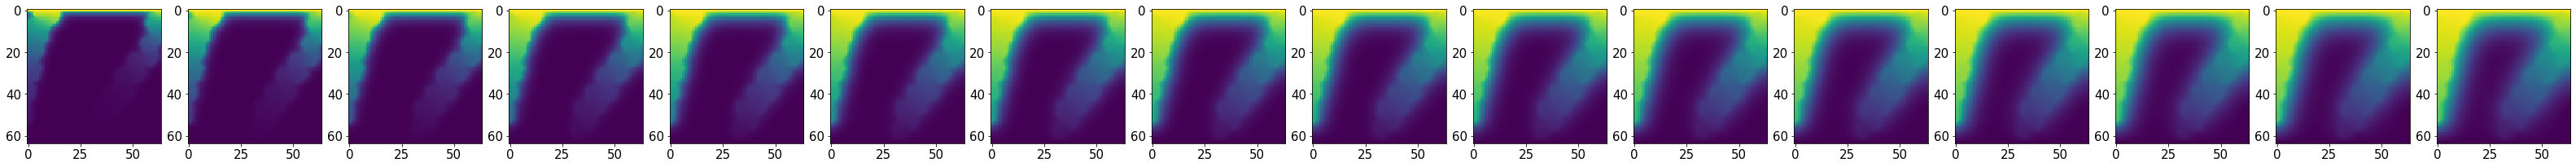

In [37]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, 1 * 3.5, forward=True)

for i in range(16):
    ax[i].imshow(pres_test_64[155, i])

#### 3.2 Load and run pre-trained operator for evaluation

In [38]:
bound_pres_large = 400
bound_pres_small = 200
start_V_cycle_num = 1
total_V_cycle_num = 76
compl_levels_singleV = [64, 32, 16, 8, 4]  # spatial level, not temporal level; temporal level is adjusted according to spatial level
multiV_levels = [[8, 4] for i in range(6)] + [[8], [8]] + \
                [[16, 8, 4] for i in range(10)] + [[16], [16]] + \
                [[32, 16, 8, 4] for i in range(14)] + [[32], [32]] + \
                [[64, 32, 16, 8, 4] for i in range(16)] + [[64], [64]] + \
                [[64, 32, 16, 8, 4] for i in range(8)] + [[64], [64]] + \
                [[64, 32, 16, 8, 4] for i in range(10)] + [[64], [64]]

compl_train_epochs_singleV = [60, 60, 60, 60, 60]
model_save_dir = '/scratch/users/suihong/MutiGrid_2D/TrainedModels/2D_MultipleTime_3/'
batch_size = 256
learning_rate = 1e-5 # 1e-4 for 4x4 to 32x32; at 64x64, the residual osscilate, thus change lr into 1e-5 (for 37-52 V-cycles);from 53 V cycles, change lr=1e-6
                     # but 1e-6 seems not further decrease the residual ... 

In [39]:
eva_V_cycle_num = 76
perm_test_64_3d = np.tile(perm_test_64[:,:, np.newaxis, :, :], (1, 1, 16, 1, 1))
perm_test_32_3d = np.tile(perm_test_32[:,:, np.newaxis, :, :], (1, 1, 8, 1, 1))
perm_test_16_3d = np.tile(perm_test_16[:,:, np.newaxis, :, :], (1, 1, 4, 1, 1))
perm_test_8_3d = np.tile(perm_test_8[:,:, np.newaxis, :, :], (1, 1, 2, 1, 1))
perm_test_4_3d = np.tile(perm_test_4[:,:, np.newaxis, :, :], (1, 1, 1, 1, 1))

# predict pressure maps using NN pipelines for test permeability maps
test_perms = [perm_test_64_3d, perm_test_32_3d, perm_test_16_3d, perm_test_8_3d, perm_test_4_3d]

pipls_list = build_Vcycle_pipls(eva_V_cycle_num, multiV_levels, model_save_dir)

1
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
2
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
3
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
4
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
5
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
6
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
7
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
8
/gpu:0
/job:localhost/replica:0/tas

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
43
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
44
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
45
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
46
/gpu:0
/job:localhost/

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
75
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
76
/gpu:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [40]:
# predict with operator including different numbers of V cycles

test_perms = test_perms
test_pred_dict = {}
test_residual_dict = {}
eva_V_cycle_num = 76
for i in range(1, eva_V_cycle_num + 1):
    print(i)
    test_pred_dict['test_pred_V' + str(i)], test_residual_dict['test_residual_V' + str(i)] = \
    pred_with_Vcycle_pipls(i, pipls_list, compl_levels_singleV, multiV_levels, test_perms)

1
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
2
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
3
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
4
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pr

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 12
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
13
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:l

/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 11
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 12
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 13
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 14
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 15
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 1

pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 19
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 20
/job:localhost/replica:0/task:0/device:GPU:0
21
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
24
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/repli

pred for V cycle: 12
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 13
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 14
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 15
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 16
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 17
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 17
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 19
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 20
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 21
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:

pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 19
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 20
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 21
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 13
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 14
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 15
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 16
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 17
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/repl

pred for V cycle: 32
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 33
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
34
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle

/job:localhost/replica:0/task:0/device:GPU:0
37
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred fo

pred for V cycle: 20
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 21
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/repl

pred for V cycle: 30
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 31
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 32
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 33
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 34
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 38
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 42
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 42
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 38
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 30
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 31
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 32
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 33
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 34
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

pred for V cycle: 21
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 11
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 12
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 13
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 14
/job:localhost/replica:0/

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 45
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 46
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 26
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 27
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

pred for V cycle: 49
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 50
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
51
pred for V cycle: 1
/job:localhost/replica:0/task:0/dev

pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 42
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 43
/job:localhost/replica:0/task:0/devic

pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 26
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 27
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 28
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 50
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 51
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 17
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 18
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 19
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 20
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 21
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 48
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 49
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 35
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 36
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 37
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 38
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r

56
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0

pred for V cycle: 43
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 44
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 45
/job:localhost/replica:0/task:0/devic

pred for V cycle: 21
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 49
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 50
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 30
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 31
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 32
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 33
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 34
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

pred for V cycle: 52
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 53
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 54
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 55
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 38
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 57
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 58
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 59
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 60
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 42
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 60
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 61
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 42
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 60
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 61
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 41
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 59
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 60
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 58
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 59
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 38
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 56
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 57
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 58
/job:localhost/replica:0/task:0/devic

pred for V cycle: 30
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 31
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 32
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 33
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 34
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

pred for V cycle: 52
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 53
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 54
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 55
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r

pred for V cycle: 22
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 23
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 26
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 49
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 50
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 11
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 12
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 13
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 14
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 45
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 46
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 65
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 66
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 67
/job:localhost/replica:0/task:0/devic

/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cy

pred for V cycle: 58
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 59
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 60
/job:localhost/replica:0/task:0/devic

pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 26
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 27
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 28
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 29
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 50
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 51
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cy

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
71
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/ta

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 43
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 44
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 62
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 63
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 64
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 65
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r

pred for V cycle: 29
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 30
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 31
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 32
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 33
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 52
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 53
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 54
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 55
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
73
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/ta

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 43
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 44
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 62
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 63
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 64
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 65
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r

/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 24
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 25
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 26
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 27
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 28
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:G

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 50
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 51
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 70
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 71
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 72
/job:localhost/replica:0/task:0/devic

pred for V cycle: 38
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 39
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 40
/job:localhost/replica:0/task:0/devic

pred for V cycle: 57
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 58
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 59
/job:localhost/replica:0/task:0/devic

pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 11
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 12
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 13
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 14
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 45
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 46
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhos

pred for V cycle: 65
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 66
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 67
/job:localhost/replica:0/task:0/devic

In [41]:
pres_test_64_3d_residual = np.zeros((perm_test_64_3d.shape[0], 1, 16, 64, 64))  
pres_test_64_3d_residual = residual_matrix(perm_test_64_3d, pres_test_64[:, np.newaxis, :, :, :])

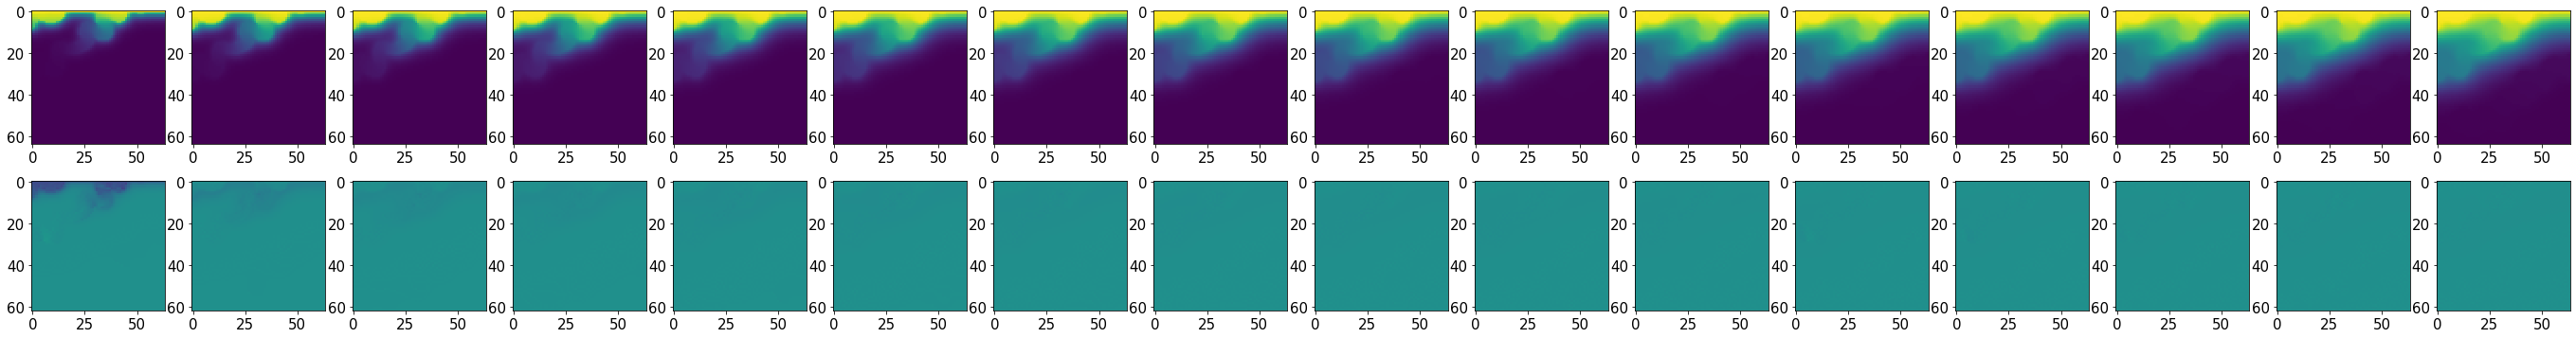

In [115]:
time_steps = 16
fig, ax = plt.subplots(2, time_steps)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(time_steps * 3, 6, forward=True)
for i in range(time_steps):
    ax[0, i].imshow(pres_test_64[255, i])
    ax[1, i].imshow(pres_test_64_3d_residual[255, 0, i],  vmin = -1, vmax = 1)

In [116]:
print(np.mean(np.abs(pres_test_64_3d_residual)))

0.013643728


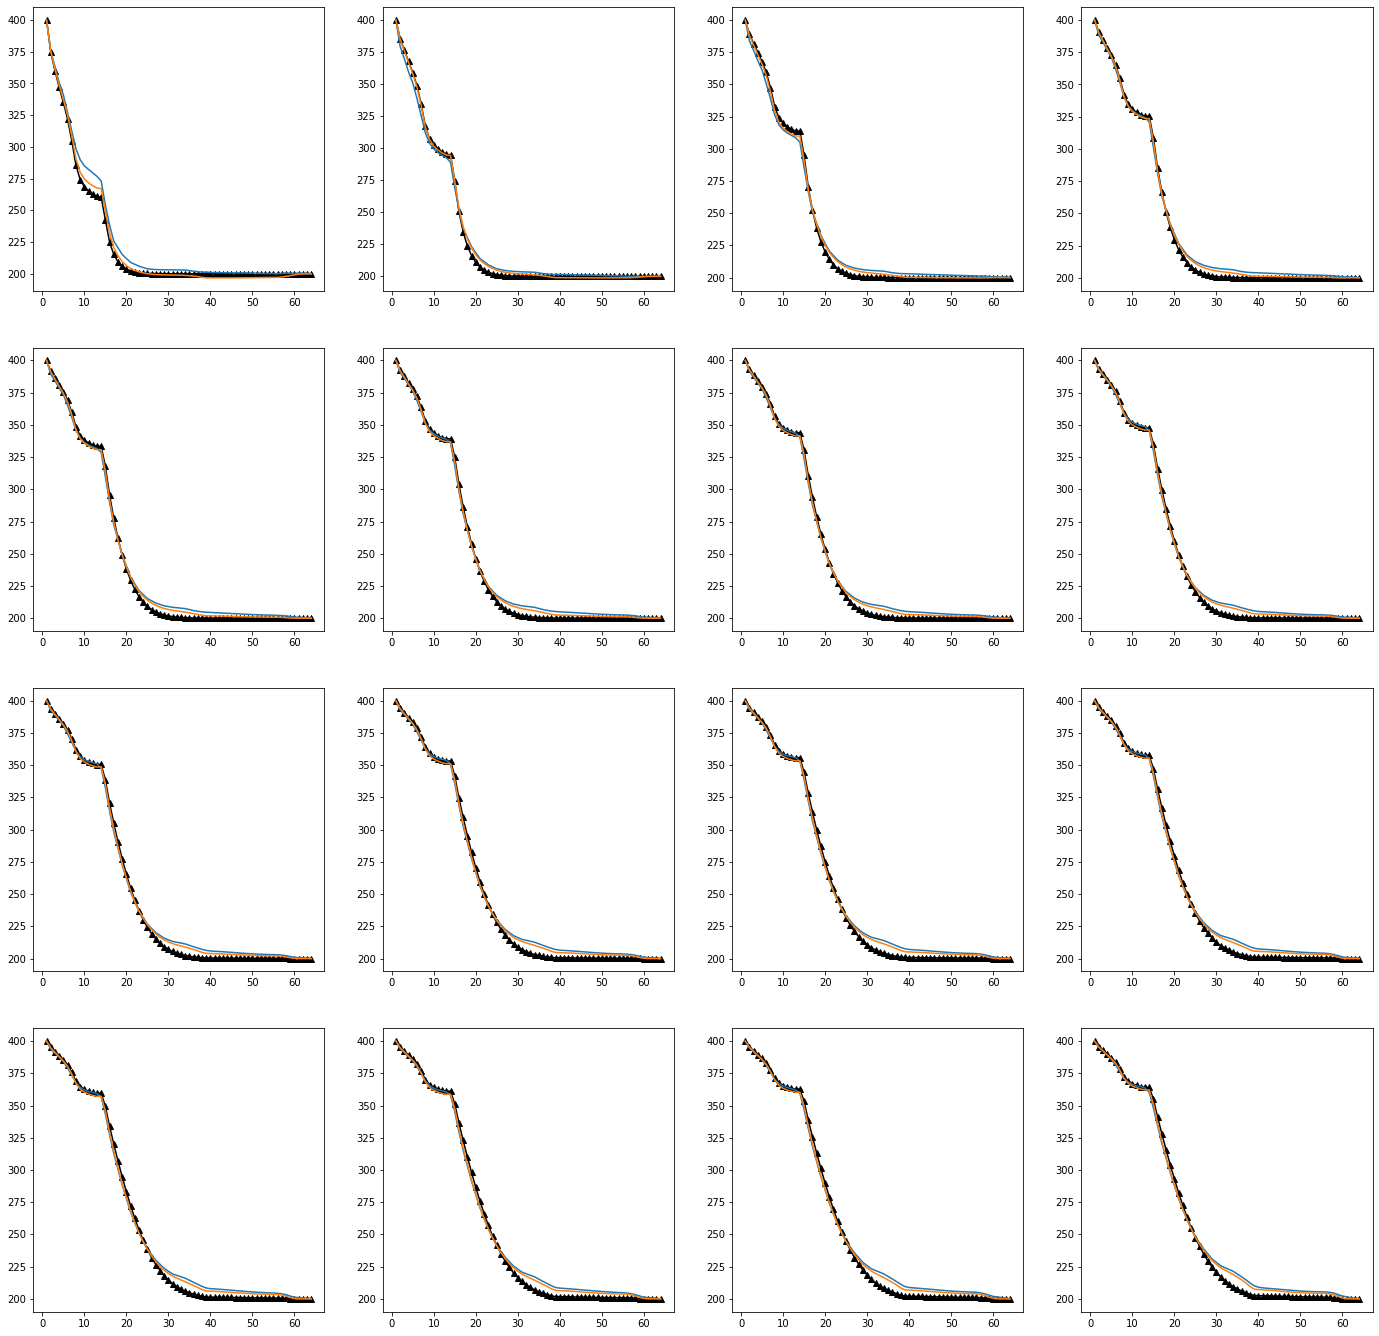

In [69]:
time_steps = 16
fig, ax = plt.subplots(4, 4)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(4*6, 4*6)

for t in range(16):
    ax[t//4, np.mod(t, 4)].plot(np.arange(1, 65), pres_test_64[255, t, :, 32], marker='^', c='k')
    
    for i in [37, 76]:
        ax[t//4, np.mod(t, 4)].plot(np.arange(1, 65), test_pred_dict['test_pred_V' + str(i)][255, 0, t, :, 32])


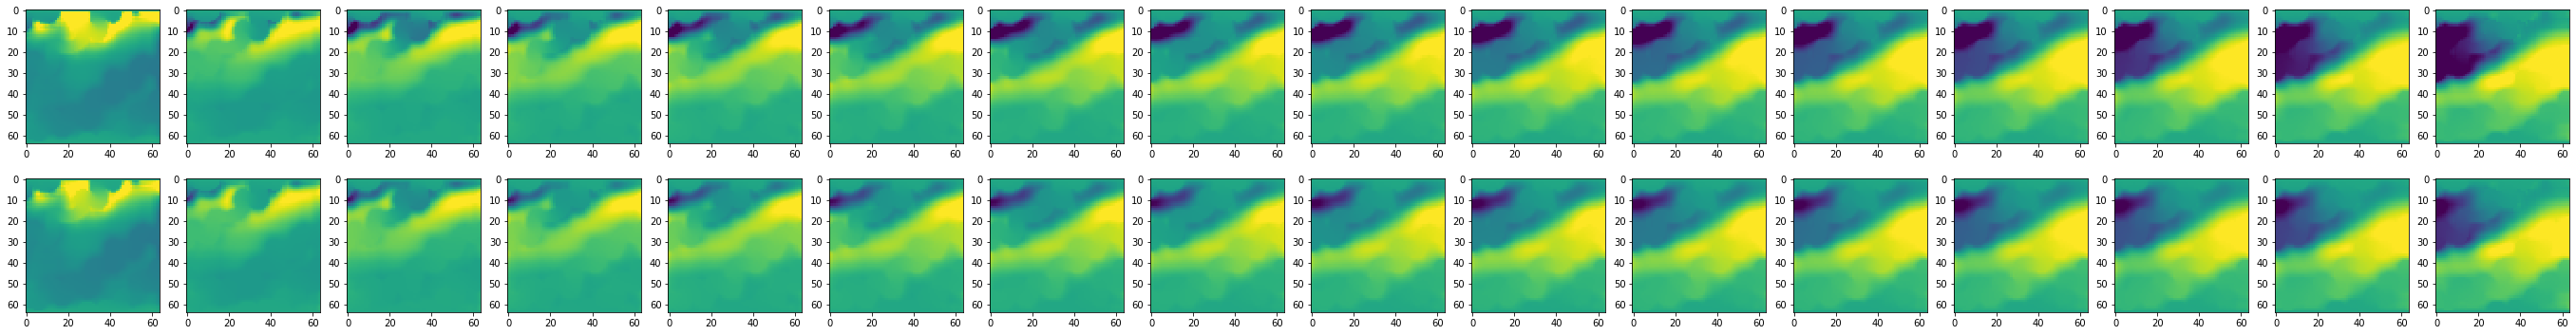

In [70]:
time_steps = 16
fig, ax = plt.subplots(2, time_steps)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(time_steps * 3, 6, forward=True)
for i in range(time_steps):
    ax[0, i].imshow(test_pred_dict['test_pred_V' + str(76)][255, 0, i] - pres_test_64[255, i],  vmin = -12, vmax = 8)
    ax[1, i].imshow((test_pred_dict['test_pred_V' + str(76)][255, 0, i]- pres_test_64[255, i]) / pres_test_64[255, i],  vmin = -0.06, vmax = 0.04)
    

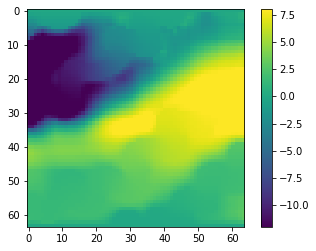

In [71]:
plt.imshow(test_pred_dict['test_pred_V' + str(76)][255, 0, i] - pres_test_64[255, i],  vmin = -12, vmax = 8)
plt.colorbar()

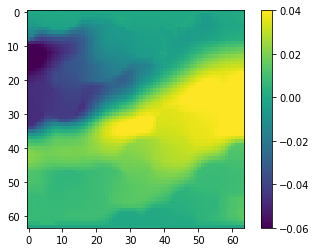

In [72]:
plt.imshow((test_pred_dict['test_pred_V' + str(76)][255, 0, i]- pres_test_64[255, i]) / pres_test_64[255, i],  vmin = -0.06, vmax = 0.04)
    
plt.colorbar()

In [ ]:
ex_indx = 255

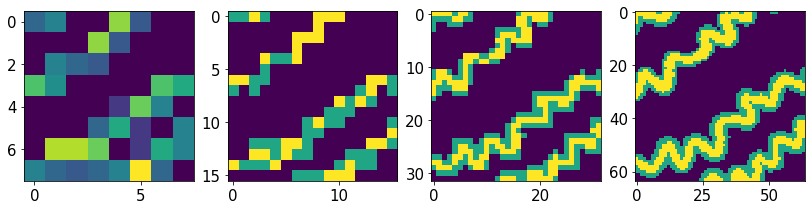

In [48]:
fig, ax = plt.subplots(1, 4)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(4 * 3.5, 3.5, forward=True)
ax[0].imshow(perm_test_8[ex_indx, 0])
ax[1].imshow(perm_test_16[ex_indx, 0])
ax[2].imshow(perm_test_32[ex_indx, 0])
ax[3].imshow(perm_test_64[ex_indx, 0])

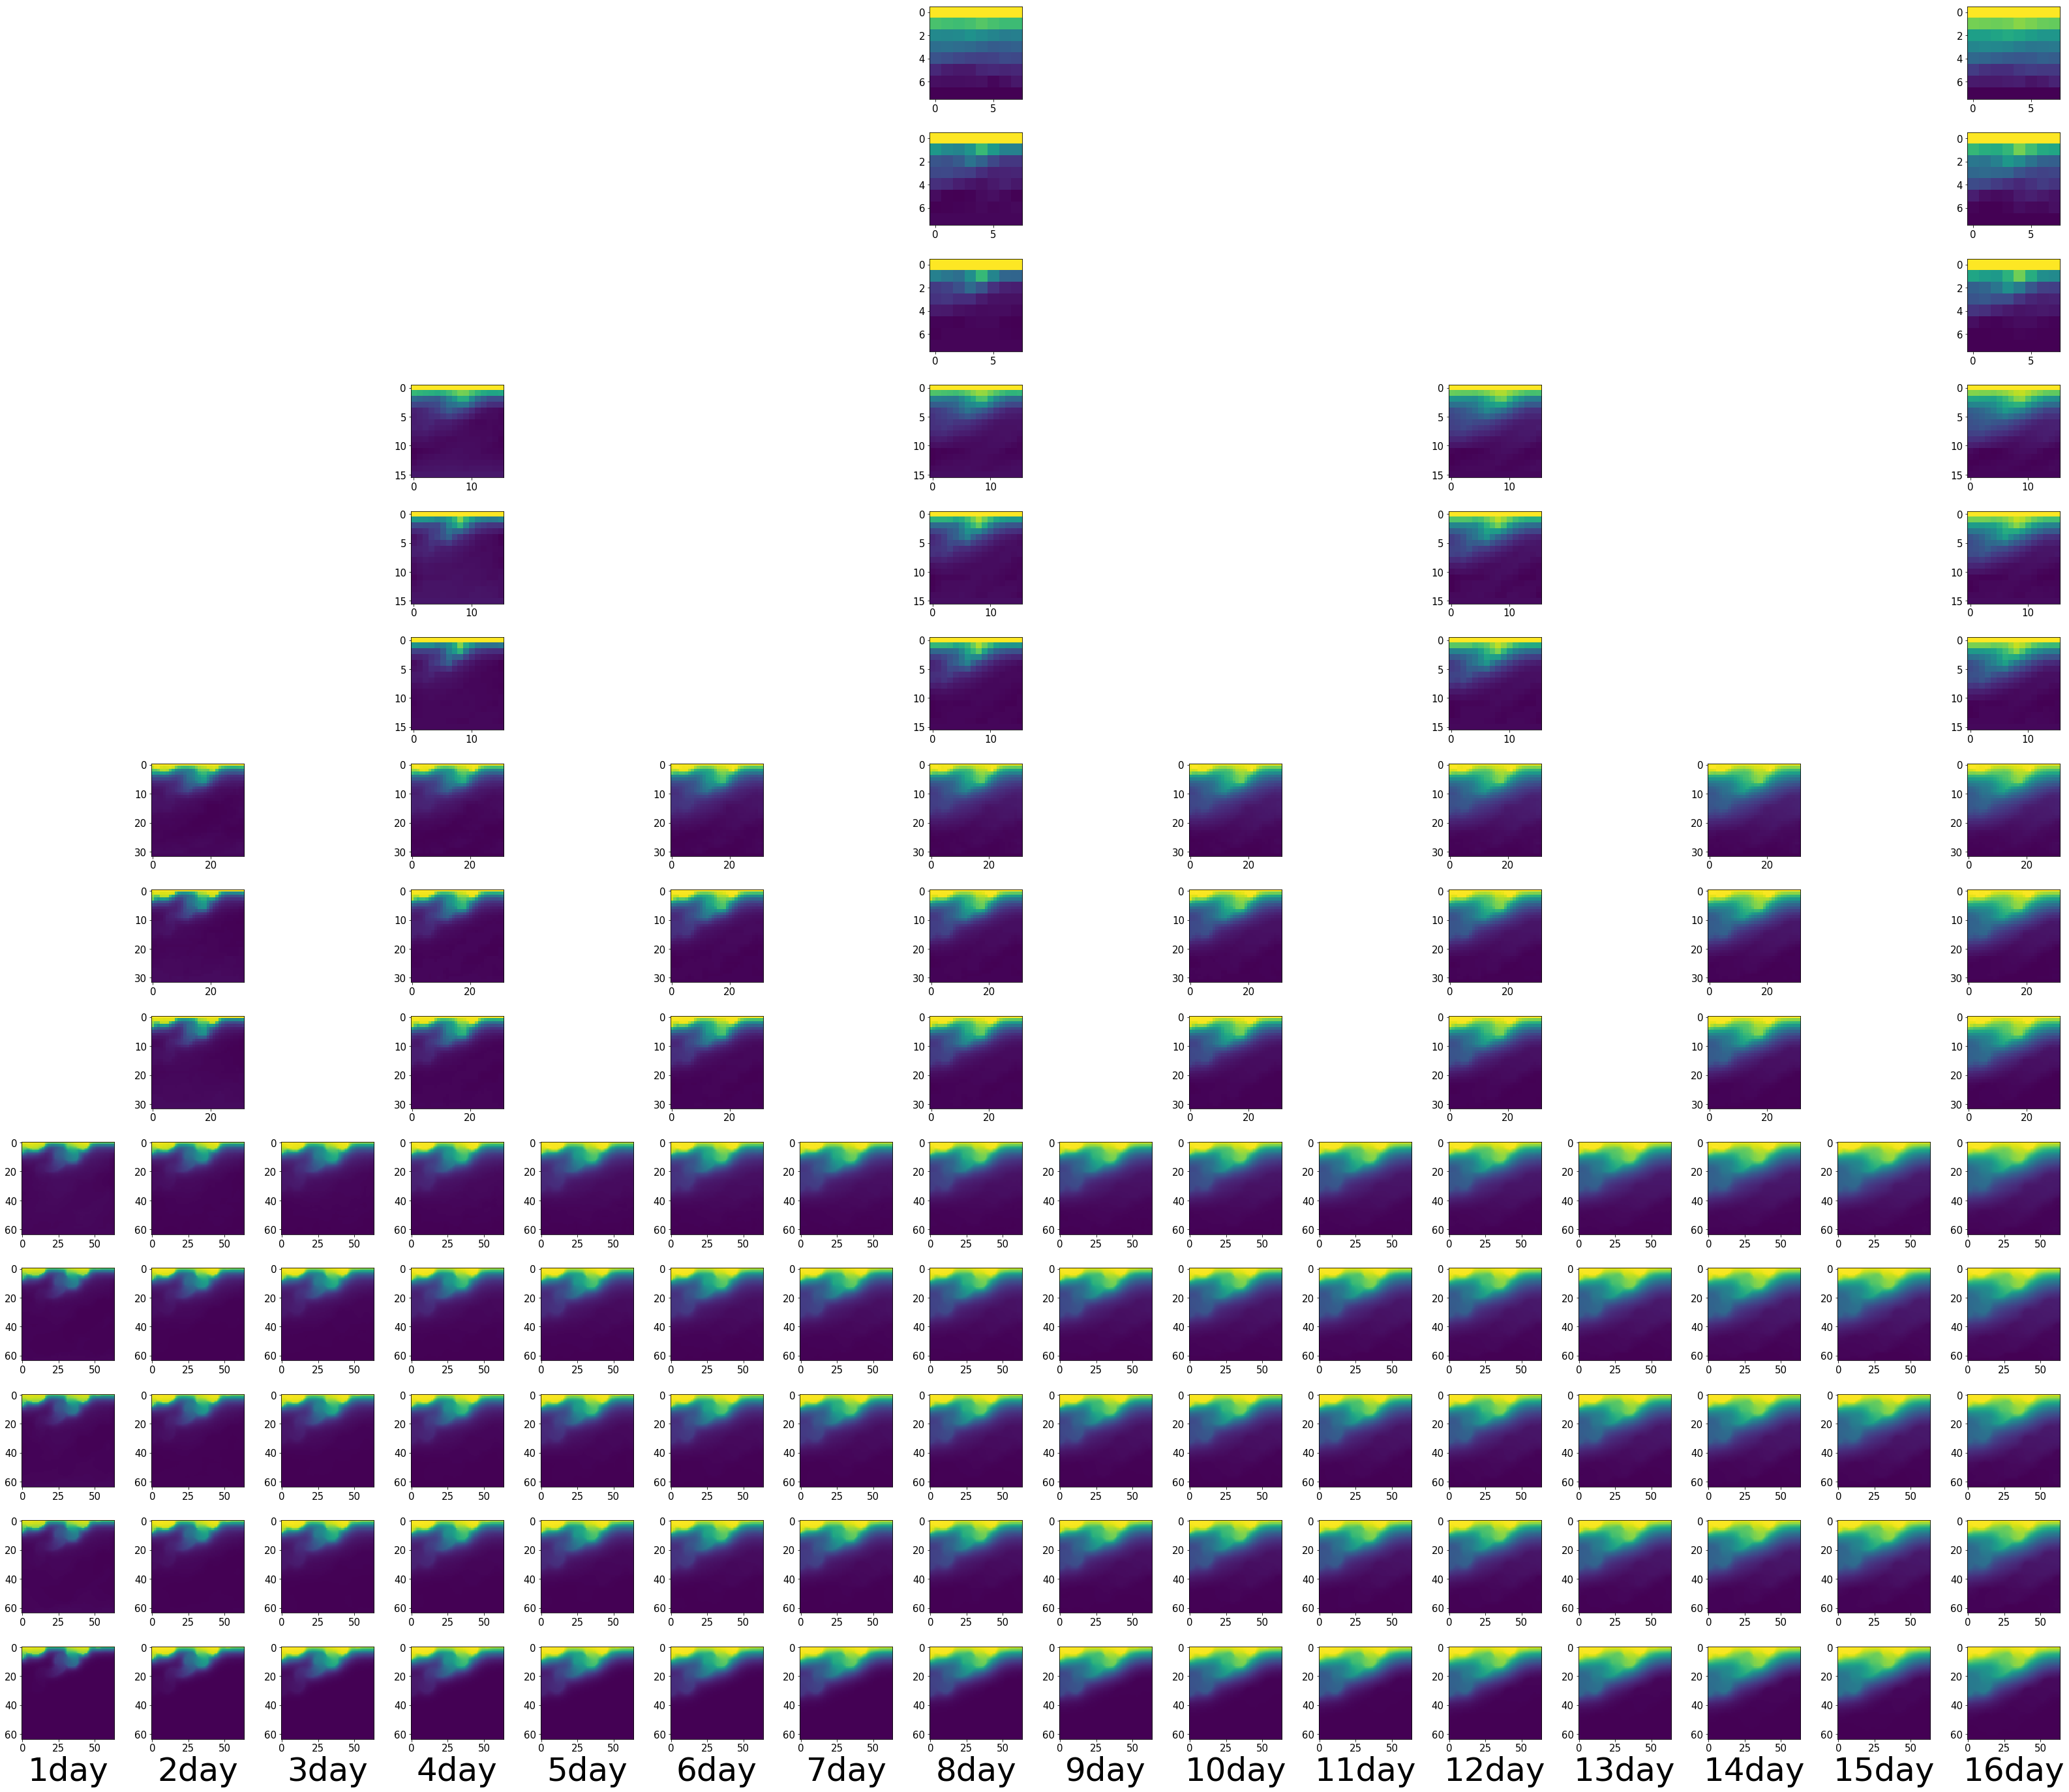

In [45]:
plt.rcParams.update({'font.size': 15})

showV_index = np.array([1, 3, 8, 9, 13, 20, 21, 25, 36, 37, 47, 57, 76])
showV_num = len(showV_index)

fig, ax = plt.subplots(showV_num + 1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, (showV_num * 1 + 1) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,showV_num):
    V_cyc = showV_index[i]
    time_step = int(16 / test_pred_dict['test_pred_V' + str(V_cyc)].shape[2])
    k = -1
    
    for j in range(16):
        if (j + 1) % time_step == 0:
            k = k + 1
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, k])
        else:
            ax[i, j].set_frame_on(False)
            ax[i, j].tick_params(bottom=False, left=False)
            ax[i, j].set(xticks=[], yticks=[])  # remove the tick lab
            
for i in range(16):
    ax[showV_num , i].imshow(pres_test_64[ex_indx, i])
    ax[showV_num, i].set_xlabel(str(i+1) + 'day', fontsize=50)
            

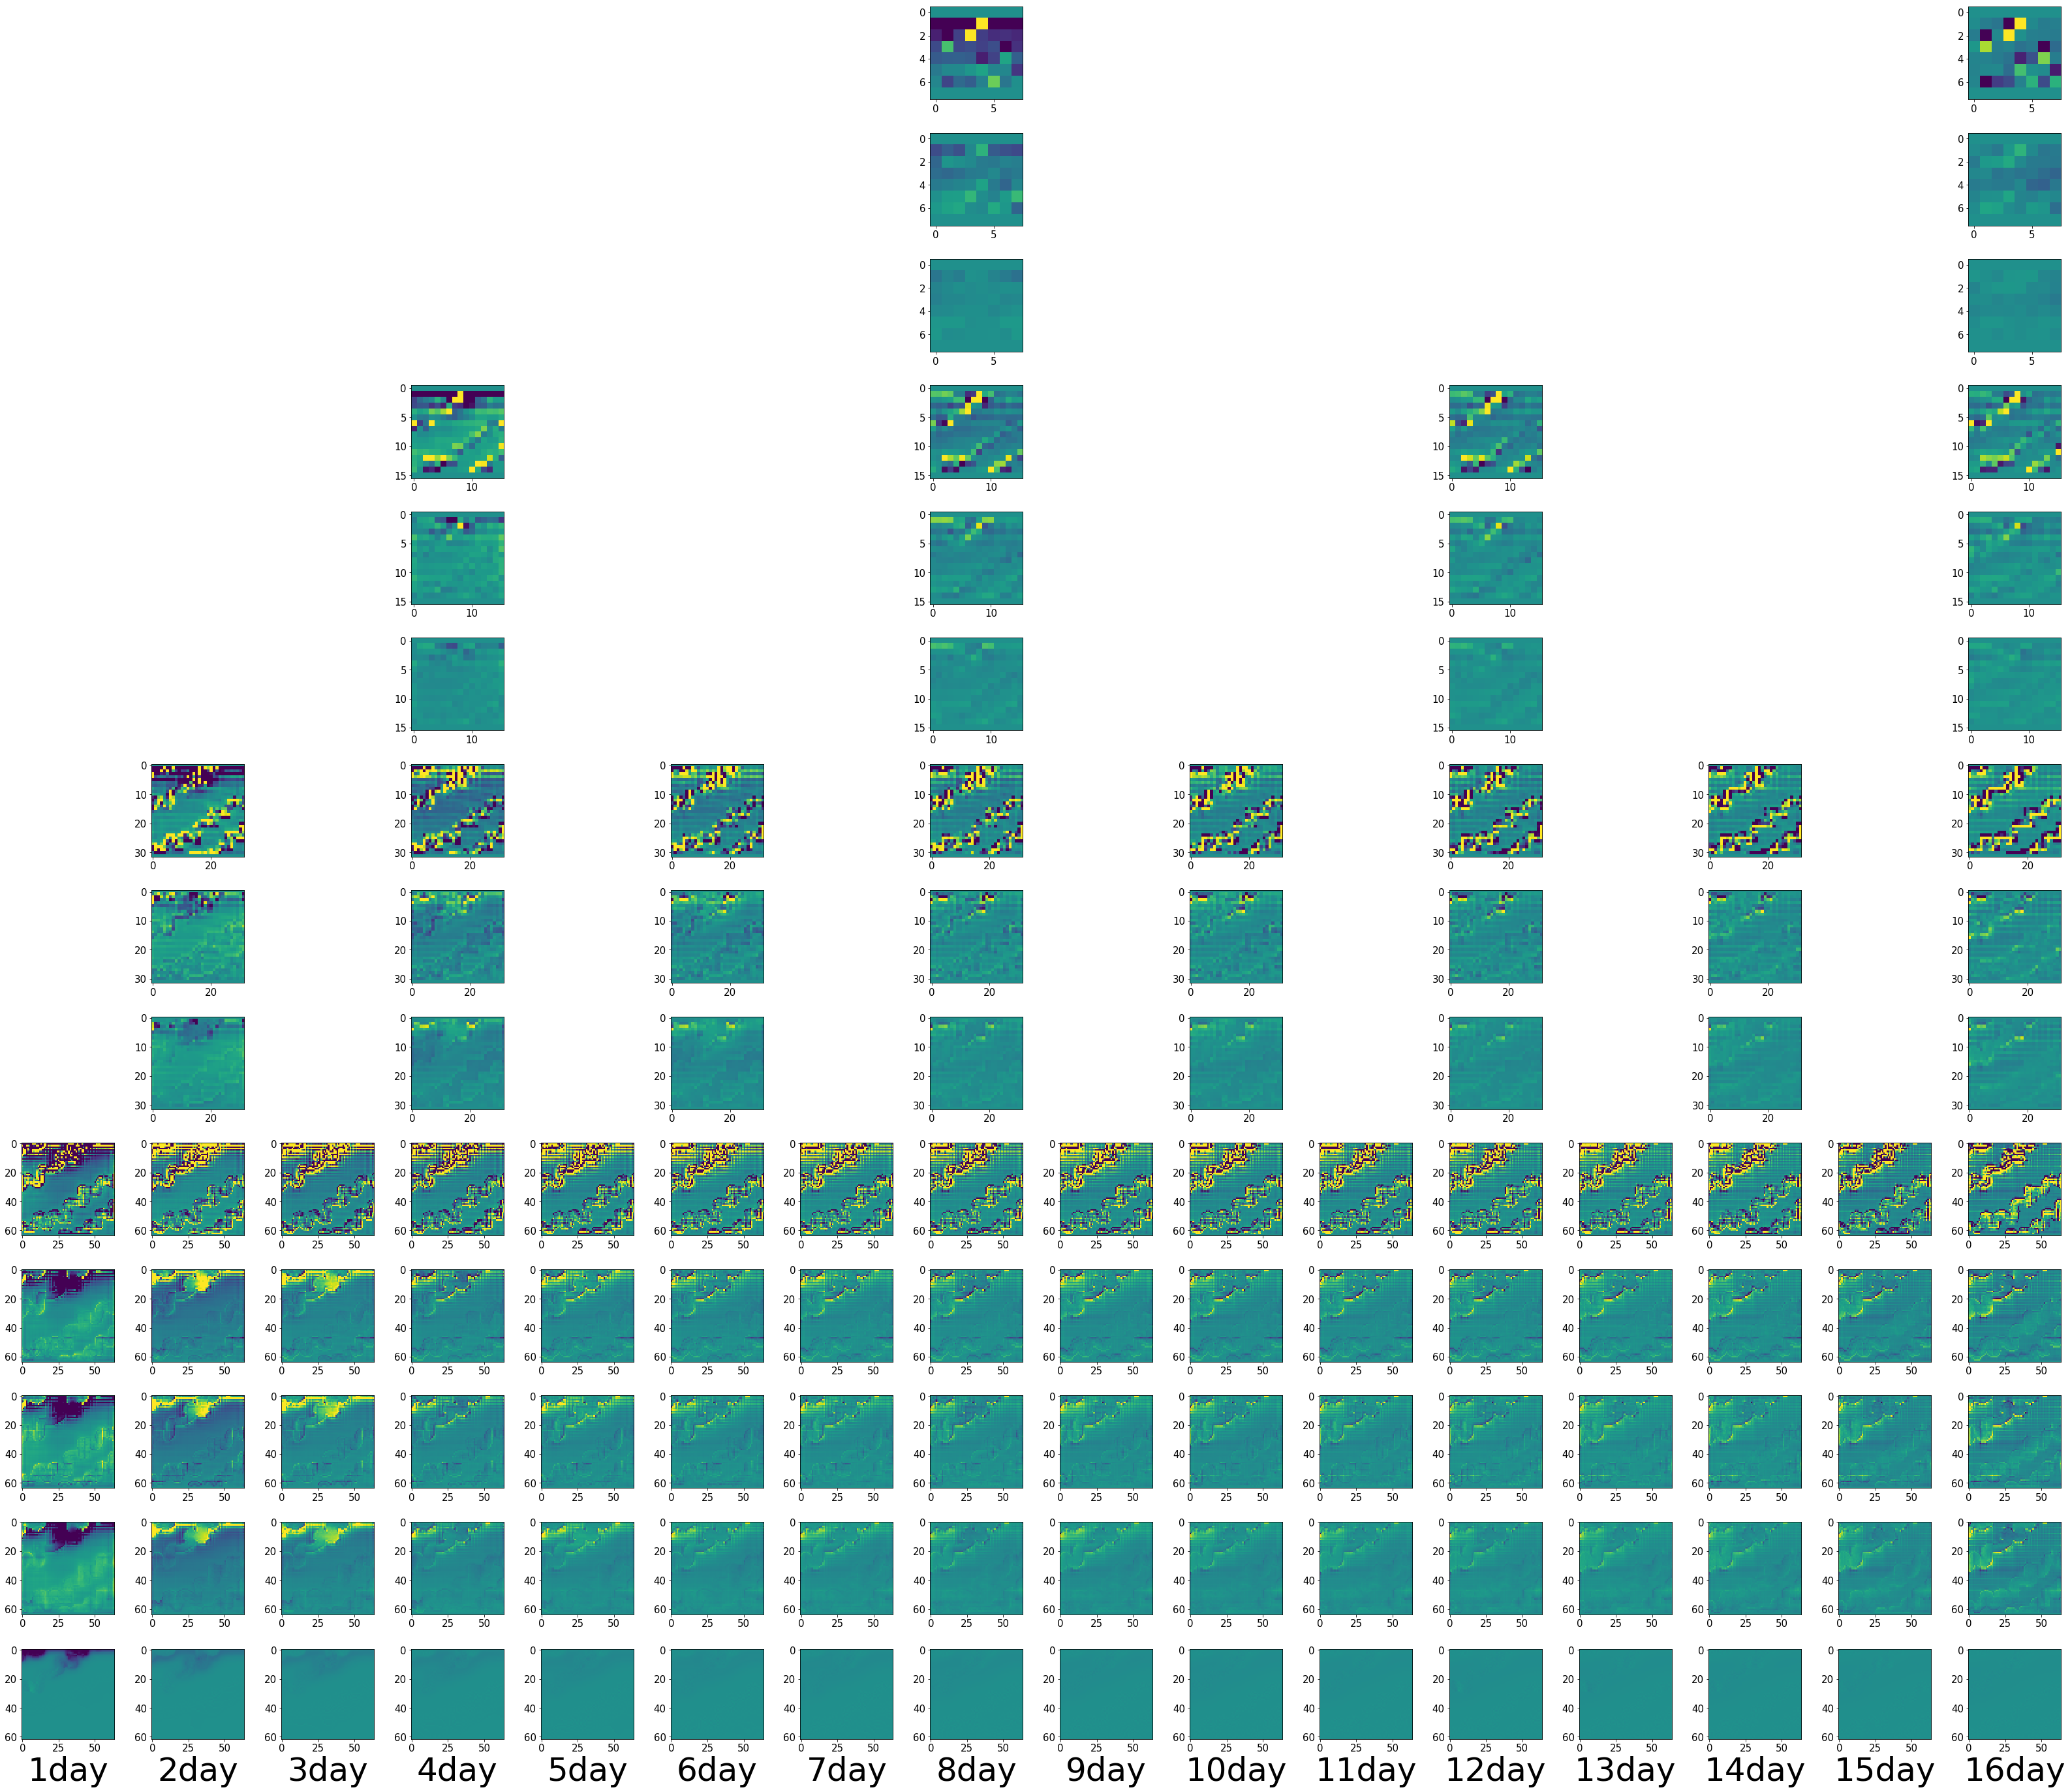

In [44]:
plt.rcParams.update({'font.size': 15})

showV_index = np.array([1, 3, 8, 9, 13, 20, 21, 25, 36, 37, 47, 57, 76])
ex_indx = 255
showV_num = len(showV_index)

fig, ax = plt.subplots(showV_num + 1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, (showV_num * 1 + 1) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,showV_num):
    V_cyc = showV_index[i]
    time_step = int(16 / test_pred_dict['test_pred_V' + str(V_cyc)].shape[2])
    k = -1
    
    for j in range(16):
        if (j + 1) % time_step == 0:
            k = k + 1
            ax[i, j].imshow(test_residual_dict['test_residual_V' + str(V_cyc)][ex_indx, 0, k],  vmin = -0.5, vmax = 0.5)
        else:
            ax[i, j].set_frame_on(False)
            ax[i, j].tick_params(bottom=False, left=False)
            ax[i, j].set(xticks=[], yticks=[])  # remove the tick lab

            
for i in range(16):
    ax[showV_num, i].imshow(pres_test_64_3d_residual[ex_indx, 0, i],  vmin = -0.5, vmax = 0.5)    
    ax[showV_num, i].set_xlabel(str(i+1) + 'day', fontsize=50)

In [92]:
ex_indx = 159

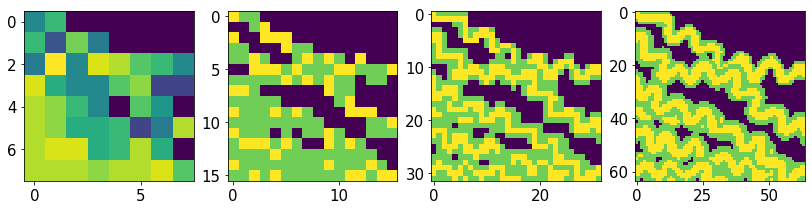

In [93]:
fig, ax = plt.subplots(1, 4)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(4 * 3.5, 3.5, forward=True)
ax[0].imshow(perm_test_8[ex_indx, 0])
ax[1].imshow(perm_test_16[ex_indx, 0])
ax[2].imshow(perm_test_32[ex_indx, 0])
ax[3].imshow(perm_test_64[ex_indx, 0])

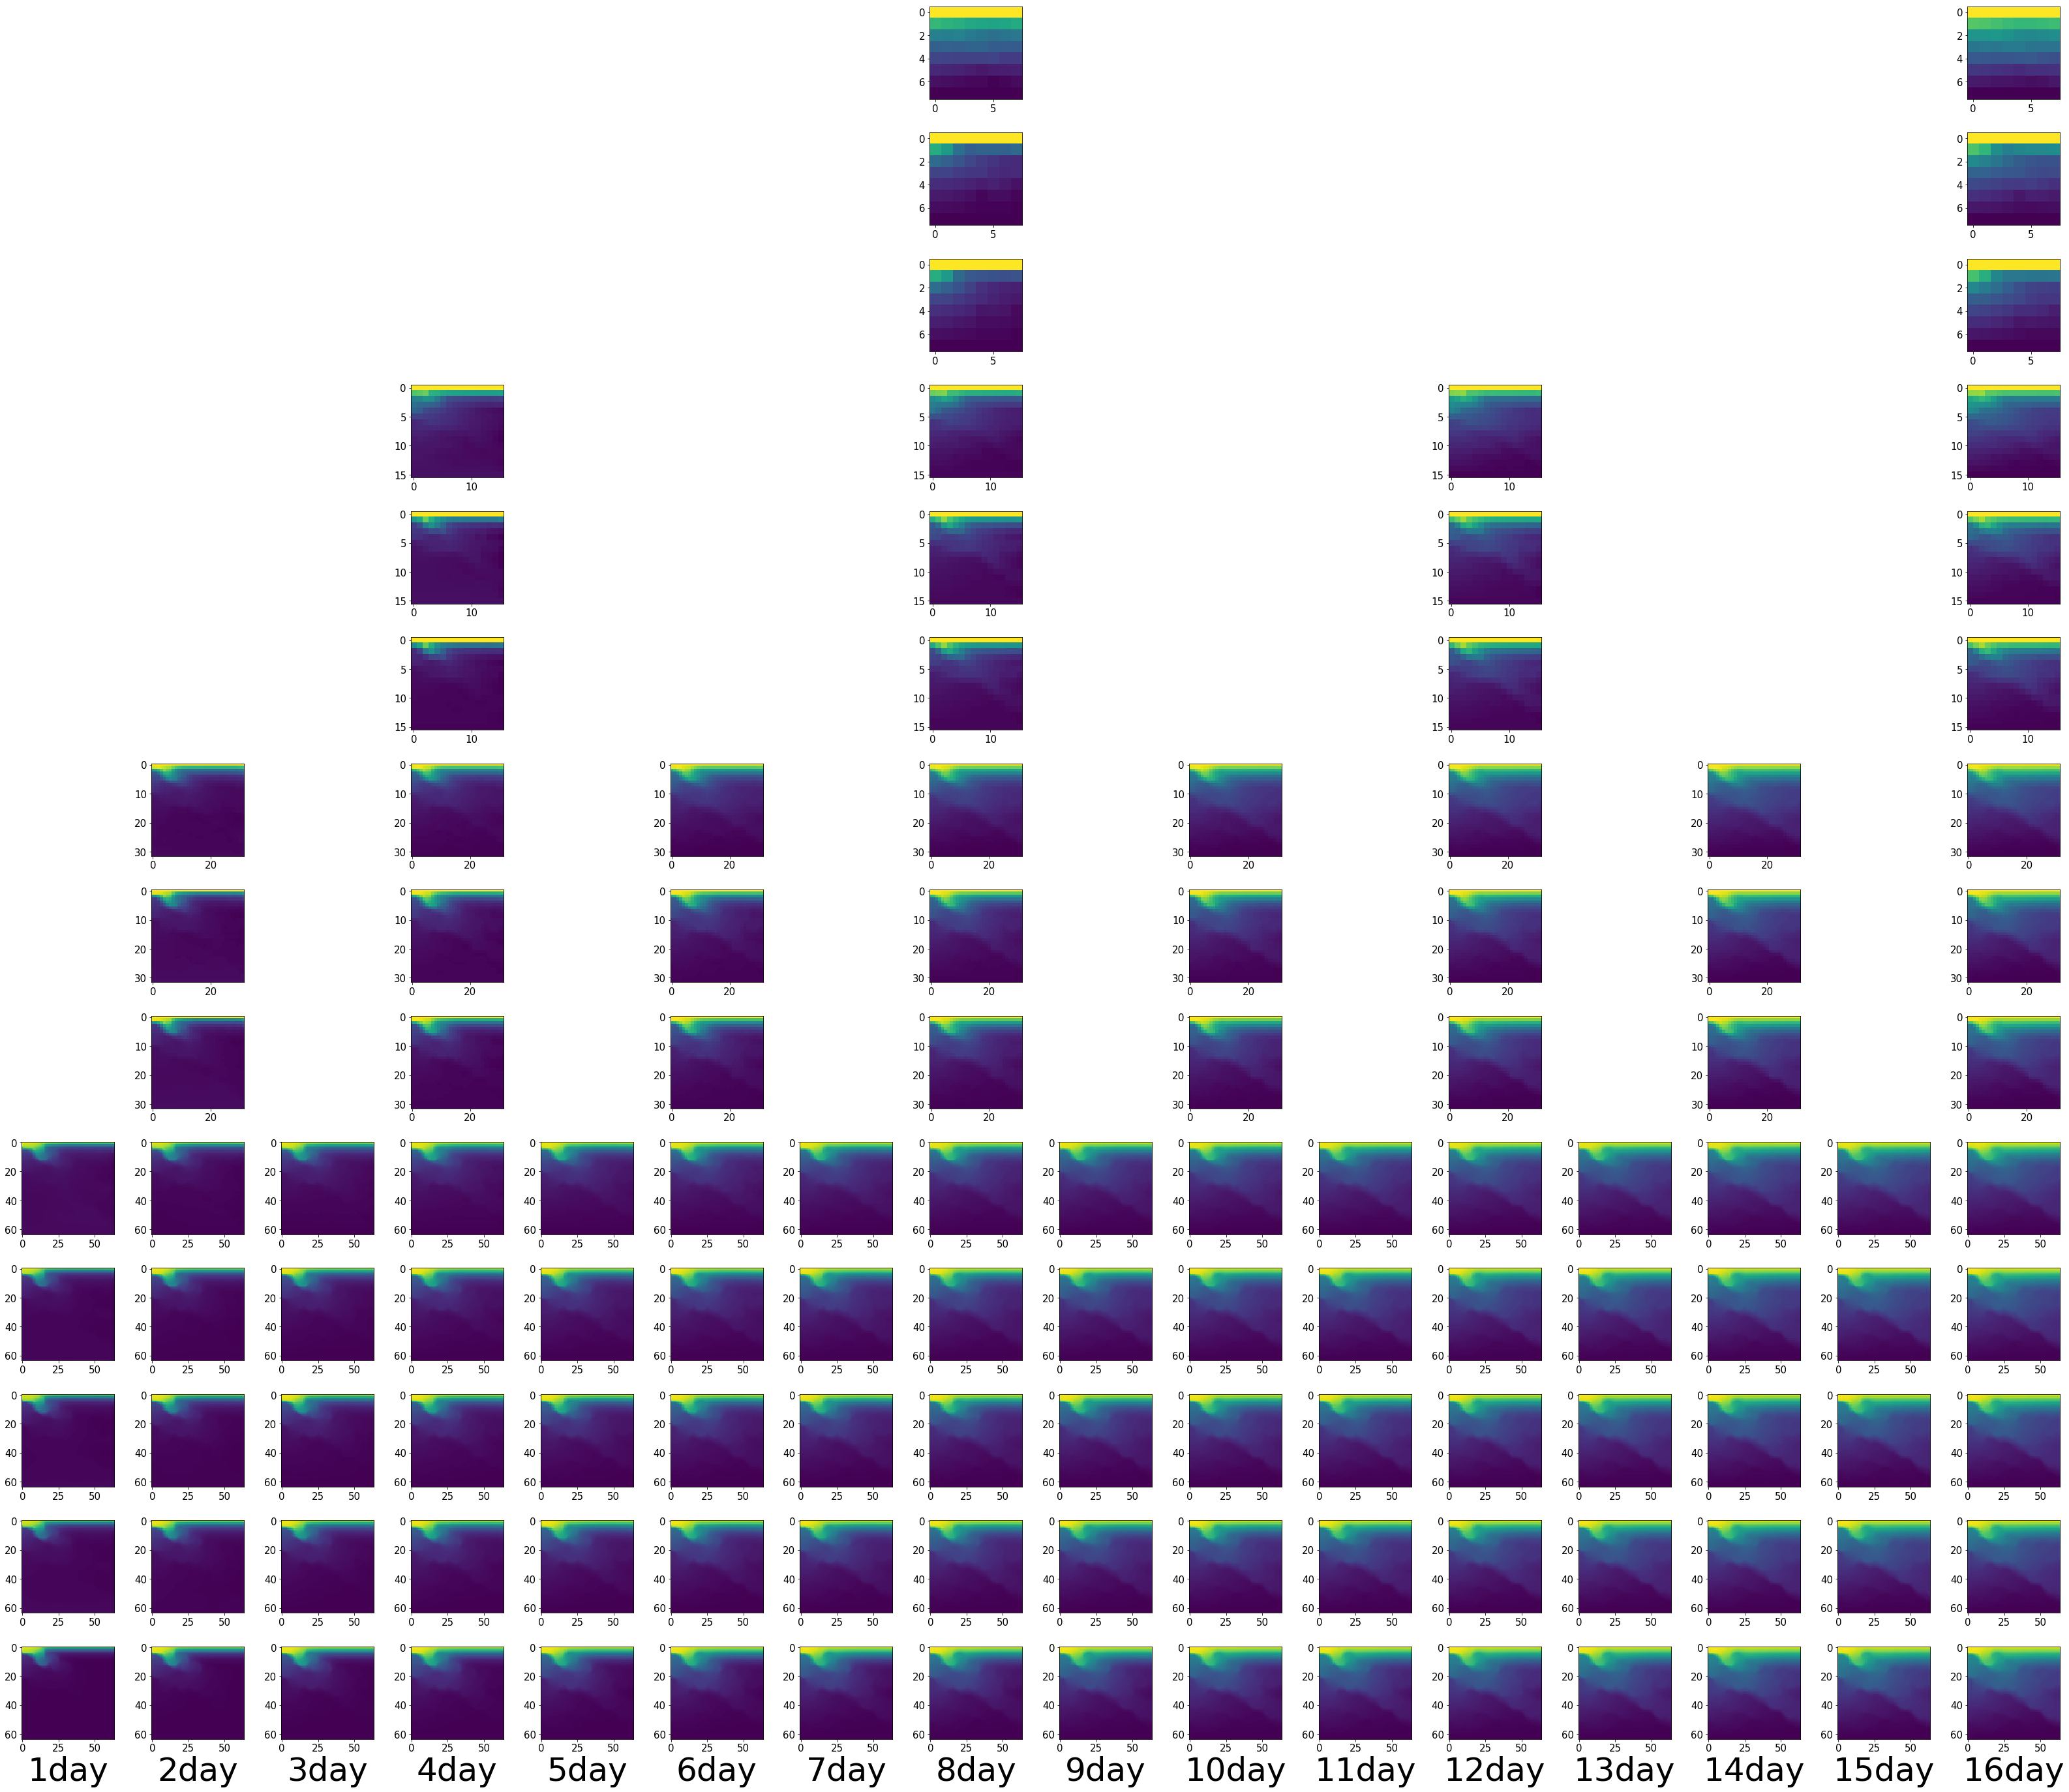

In [94]:
plt.rcParams.update({'font.size': 15})

showV_index = np.array([1, 3, 8, 9, 13, 20, 21, 25, 36, 37, 47, 57, 76])
showV_num = len(showV_index)

fig, ax = plt.subplots(showV_num + 1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, (showV_num * 1 + 1) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,showV_num):
    V_cyc = showV_index[i]
    time_step = int(16 / test_pred_dict['test_pred_V' + str(V_cyc)].shape[2])
    k = -1
    
    for j in range(16):
        if (j + 1) % time_step == 0:
            k = k + 1
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, k])
        else:
            ax[i, j].set_frame_on(False)
            ax[i, j].tick_params(bottom=False, left=False)
            ax[i, j].set(xticks=[], yticks=[])  # remove the tick lab
            
for i in range(16):
    ax[showV_num , i].imshow(pres_test_64[ex_indx, i])
    ax[showV_num, i].set_xlabel(str(i+1) + 'day', fontsize=50)
            

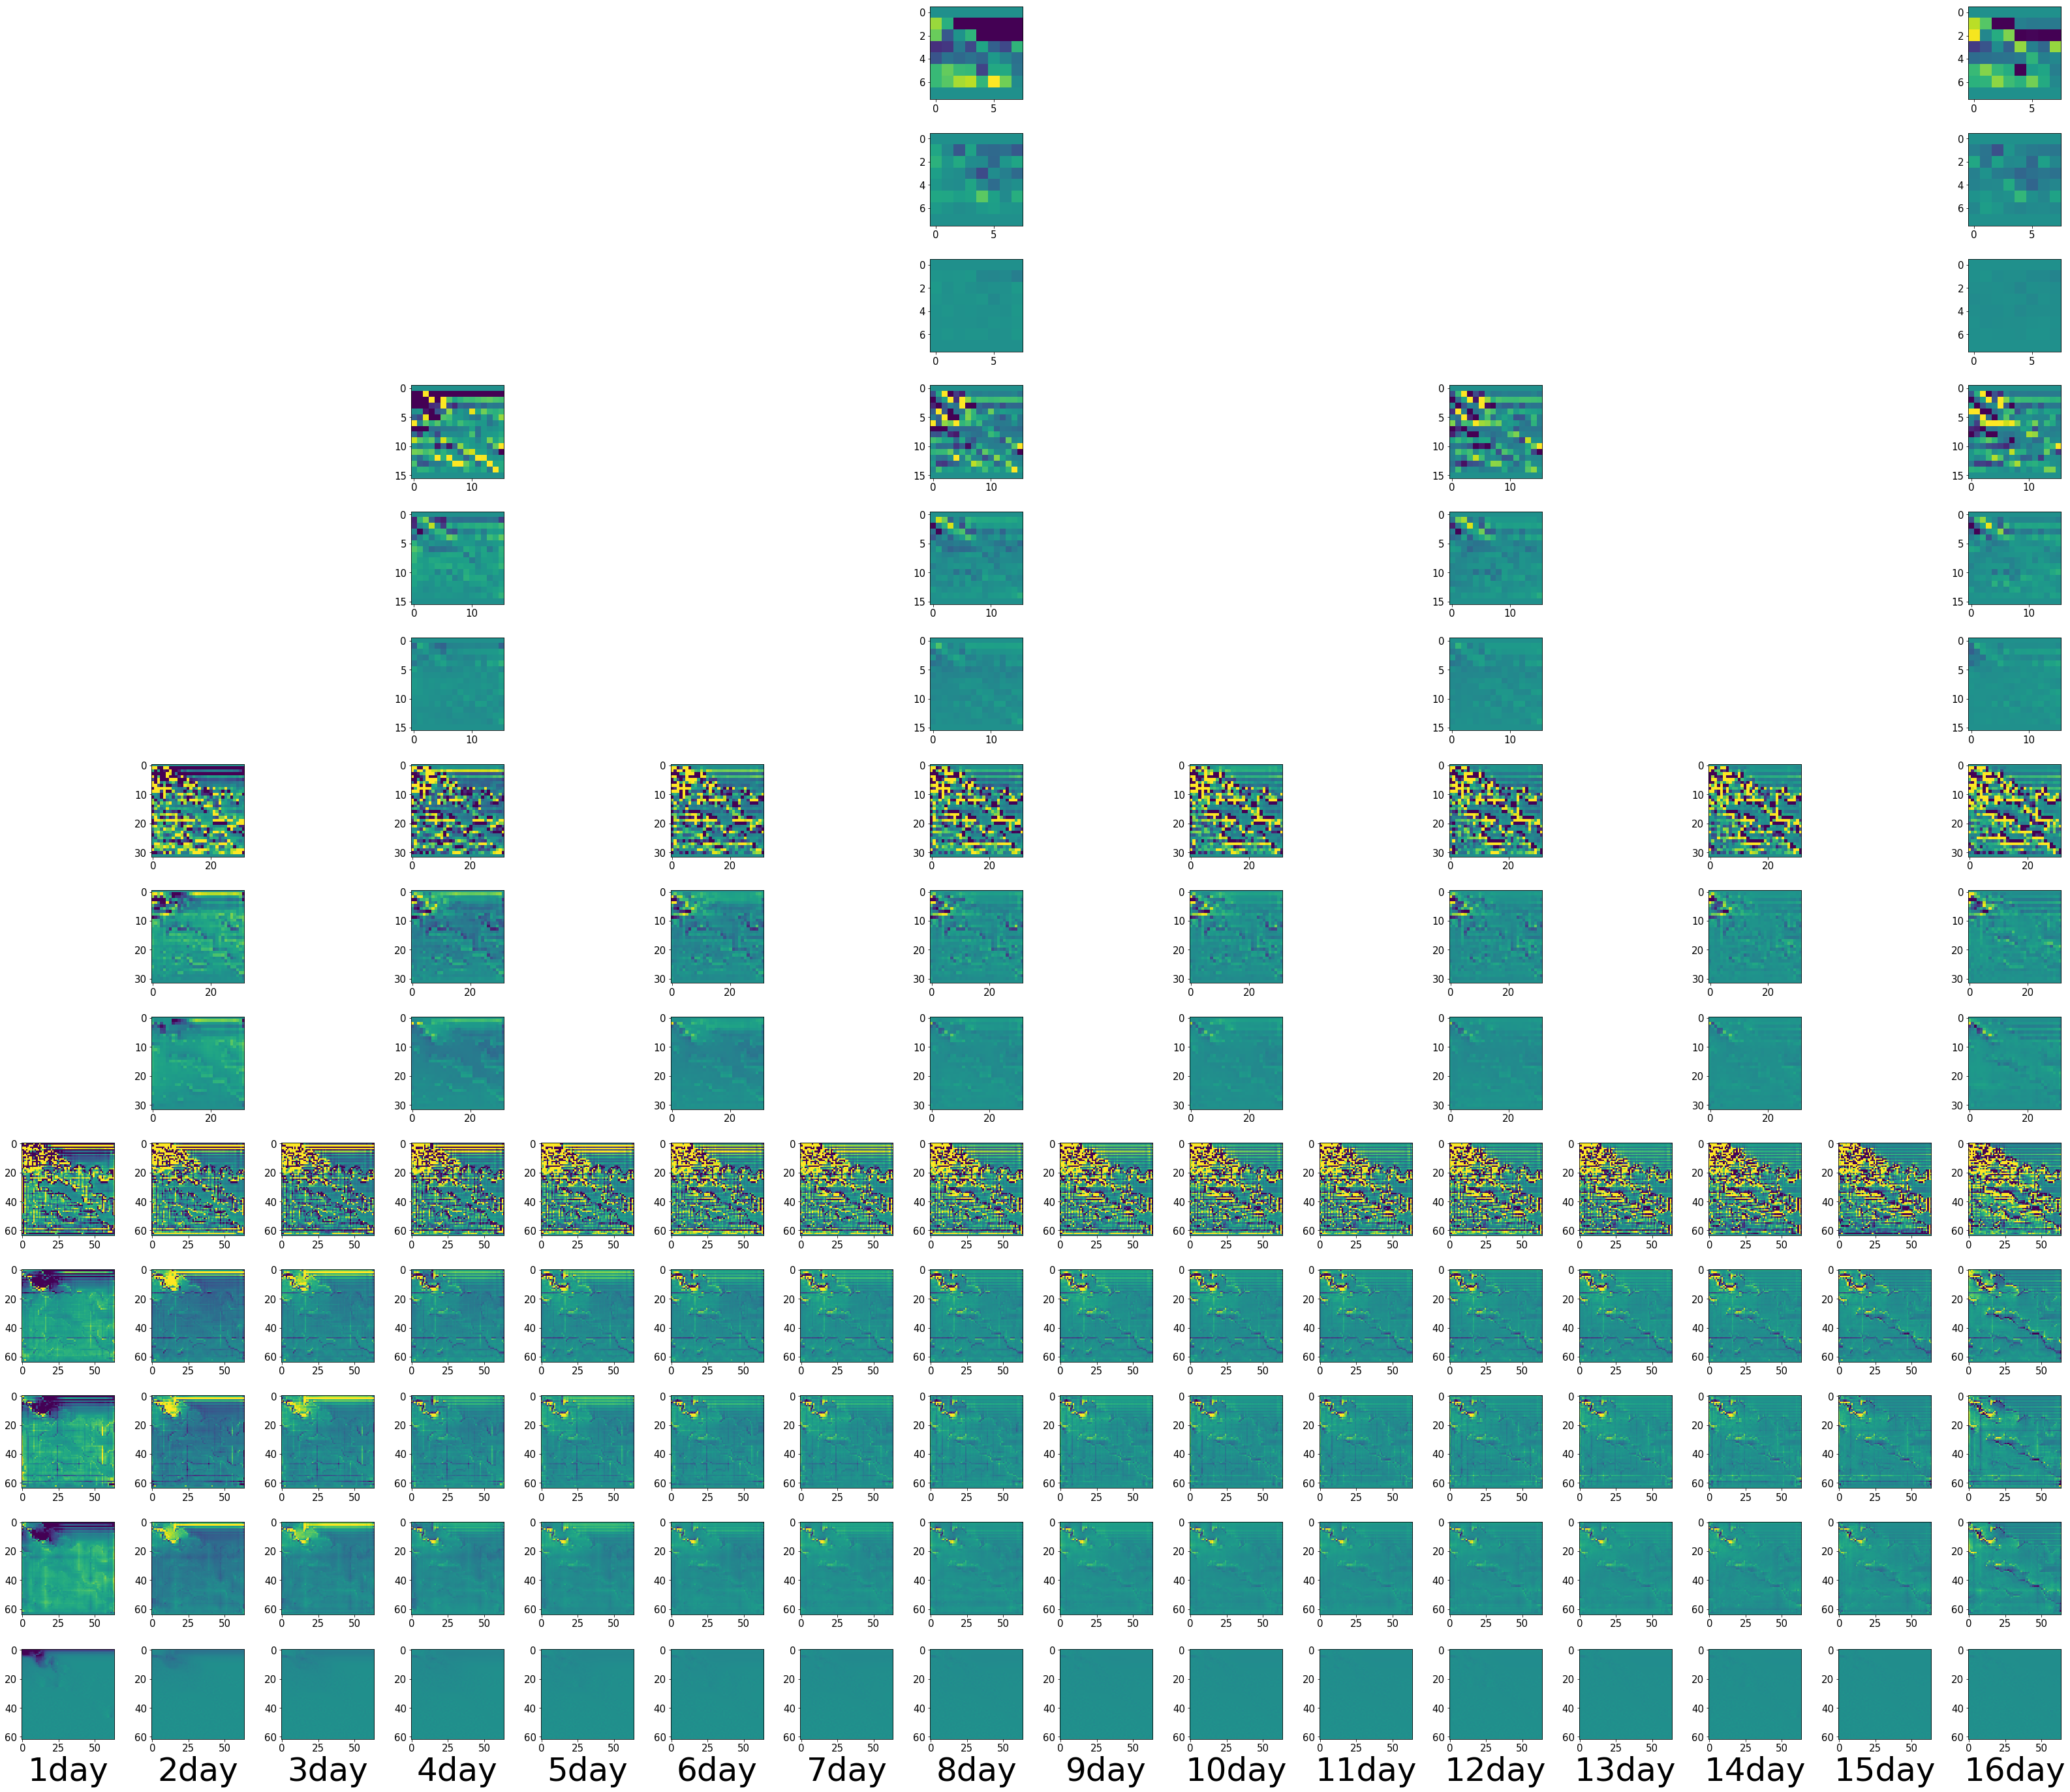

In [95]:
plt.rcParams.update({'font.size': 15})

showV_index = np.array([1, 3, 8, 9, 13, 20, 21, 25, 36, 37, 47, 57, 76])
showV_num = len(showV_index)

fig, ax = plt.subplots(showV_num + 1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, (showV_num * 1 + 1) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,showV_num):
    V_cyc = showV_index[i]
    time_step = int(16 / test_pred_dict['test_pred_V' + str(V_cyc)].shape[2])
    k = -1
    
    for j in range(16):
        if (j + 1) % time_step == 0:
            k = k + 1
            ax[i, j].imshow(test_residual_dict['test_residual_V' + str(V_cyc)][ex_indx, 0, k],  vmin = -0.5, vmax = 0.5)
        else:
            ax[i, j].set_frame_on(False)
            ax[i, j].tick_params(bottom=False, left=False)
            ax[i, j].set(xticks=[], yticks=[])  # remove the tick lab

            
for i in range(16):
    ax[showV_num, i].imshow(pres_test_64_3d_residual[ex_indx, 0, i],  vmin = -0.5, vmax = 0.5)    
    ax[showV_num, i].set_xlabel(str(i+1) + 'day', fontsize=50)

In [162]:
ex_indx = 449

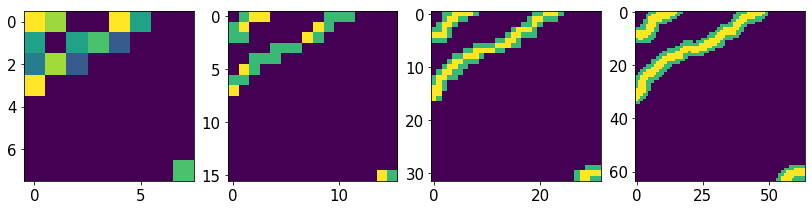

In [163]:
fig, ax = plt.subplots(1, 4)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(4 * 3.5, 3.5, forward=True)
ax[0].imshow(perm_test_8[ex_indx, 0])
ax[1].imshow(perm_test_16[ex_indx, 0])
ax[2].imshow(perm_test_32[ex_indx, 0])
ax[3].imshow(perm_test_64[ex_indx, 0])

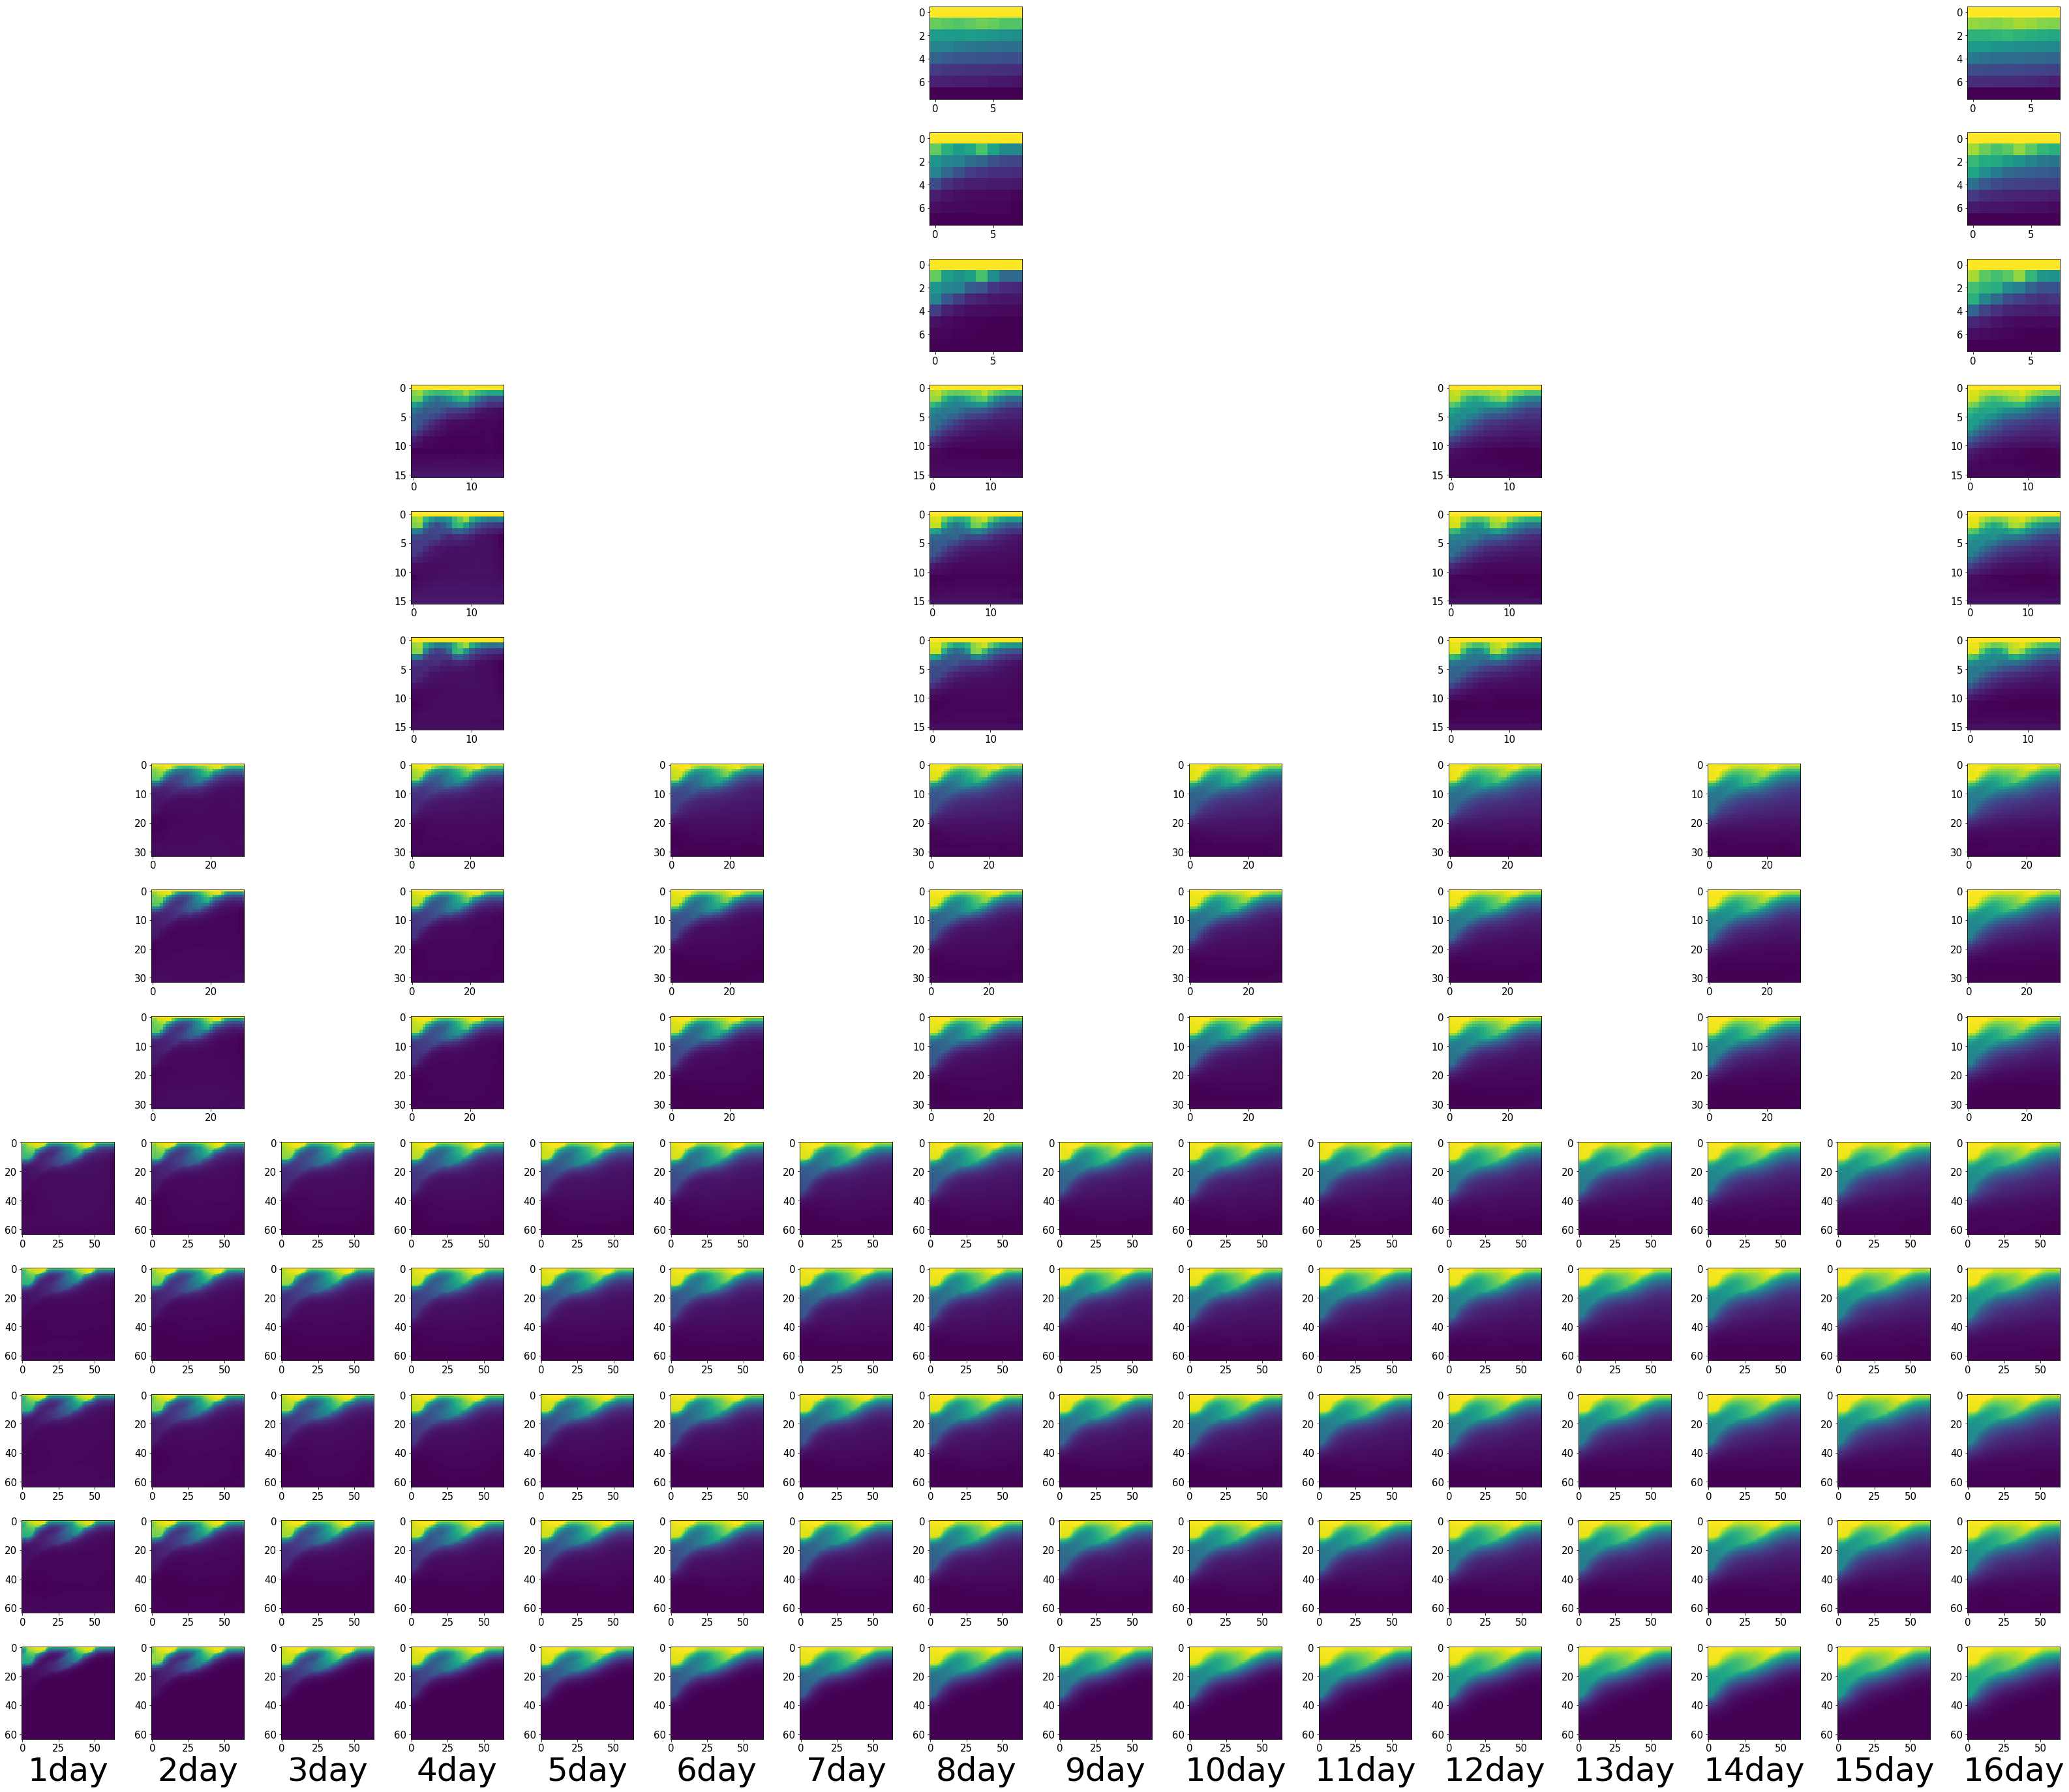

In [99]:
plt.rcParams.update({'font.size': 15})

showV_index = np.array([1, 3, 8, 9, 13, 20, 21, 25, 36, 37, 47, 57, 76])
showV_num = len(showV_index)

fig, ax = plt.subplots(showV_num + 1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, (showV_num * 1 + 1) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,showV_num):
    V_cyc = showV_index[i]
    time_step = int(16 / test_pred_dict['test_pred_V' + str(V_cyc)].shape[2])
    k = -1
    
    for j in range(16):
        if (j + 1) % time_step == 0:
            k = k + 1
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, k])
        else:
            ax[i, j].set_frame_on(False)
            ax[i, j].tick_params(bottom=False, left=False)
            ax[i, j].set(xticks=[], yticks=[])  # remove the tick lab
            
for i in range(16):
    ax[showV_num , i].imshow(pres_test_64[ex_indx, i])
    ax[showV_num, i].set_xlabel(str(i+1) + 'day', fontsize=50)
            

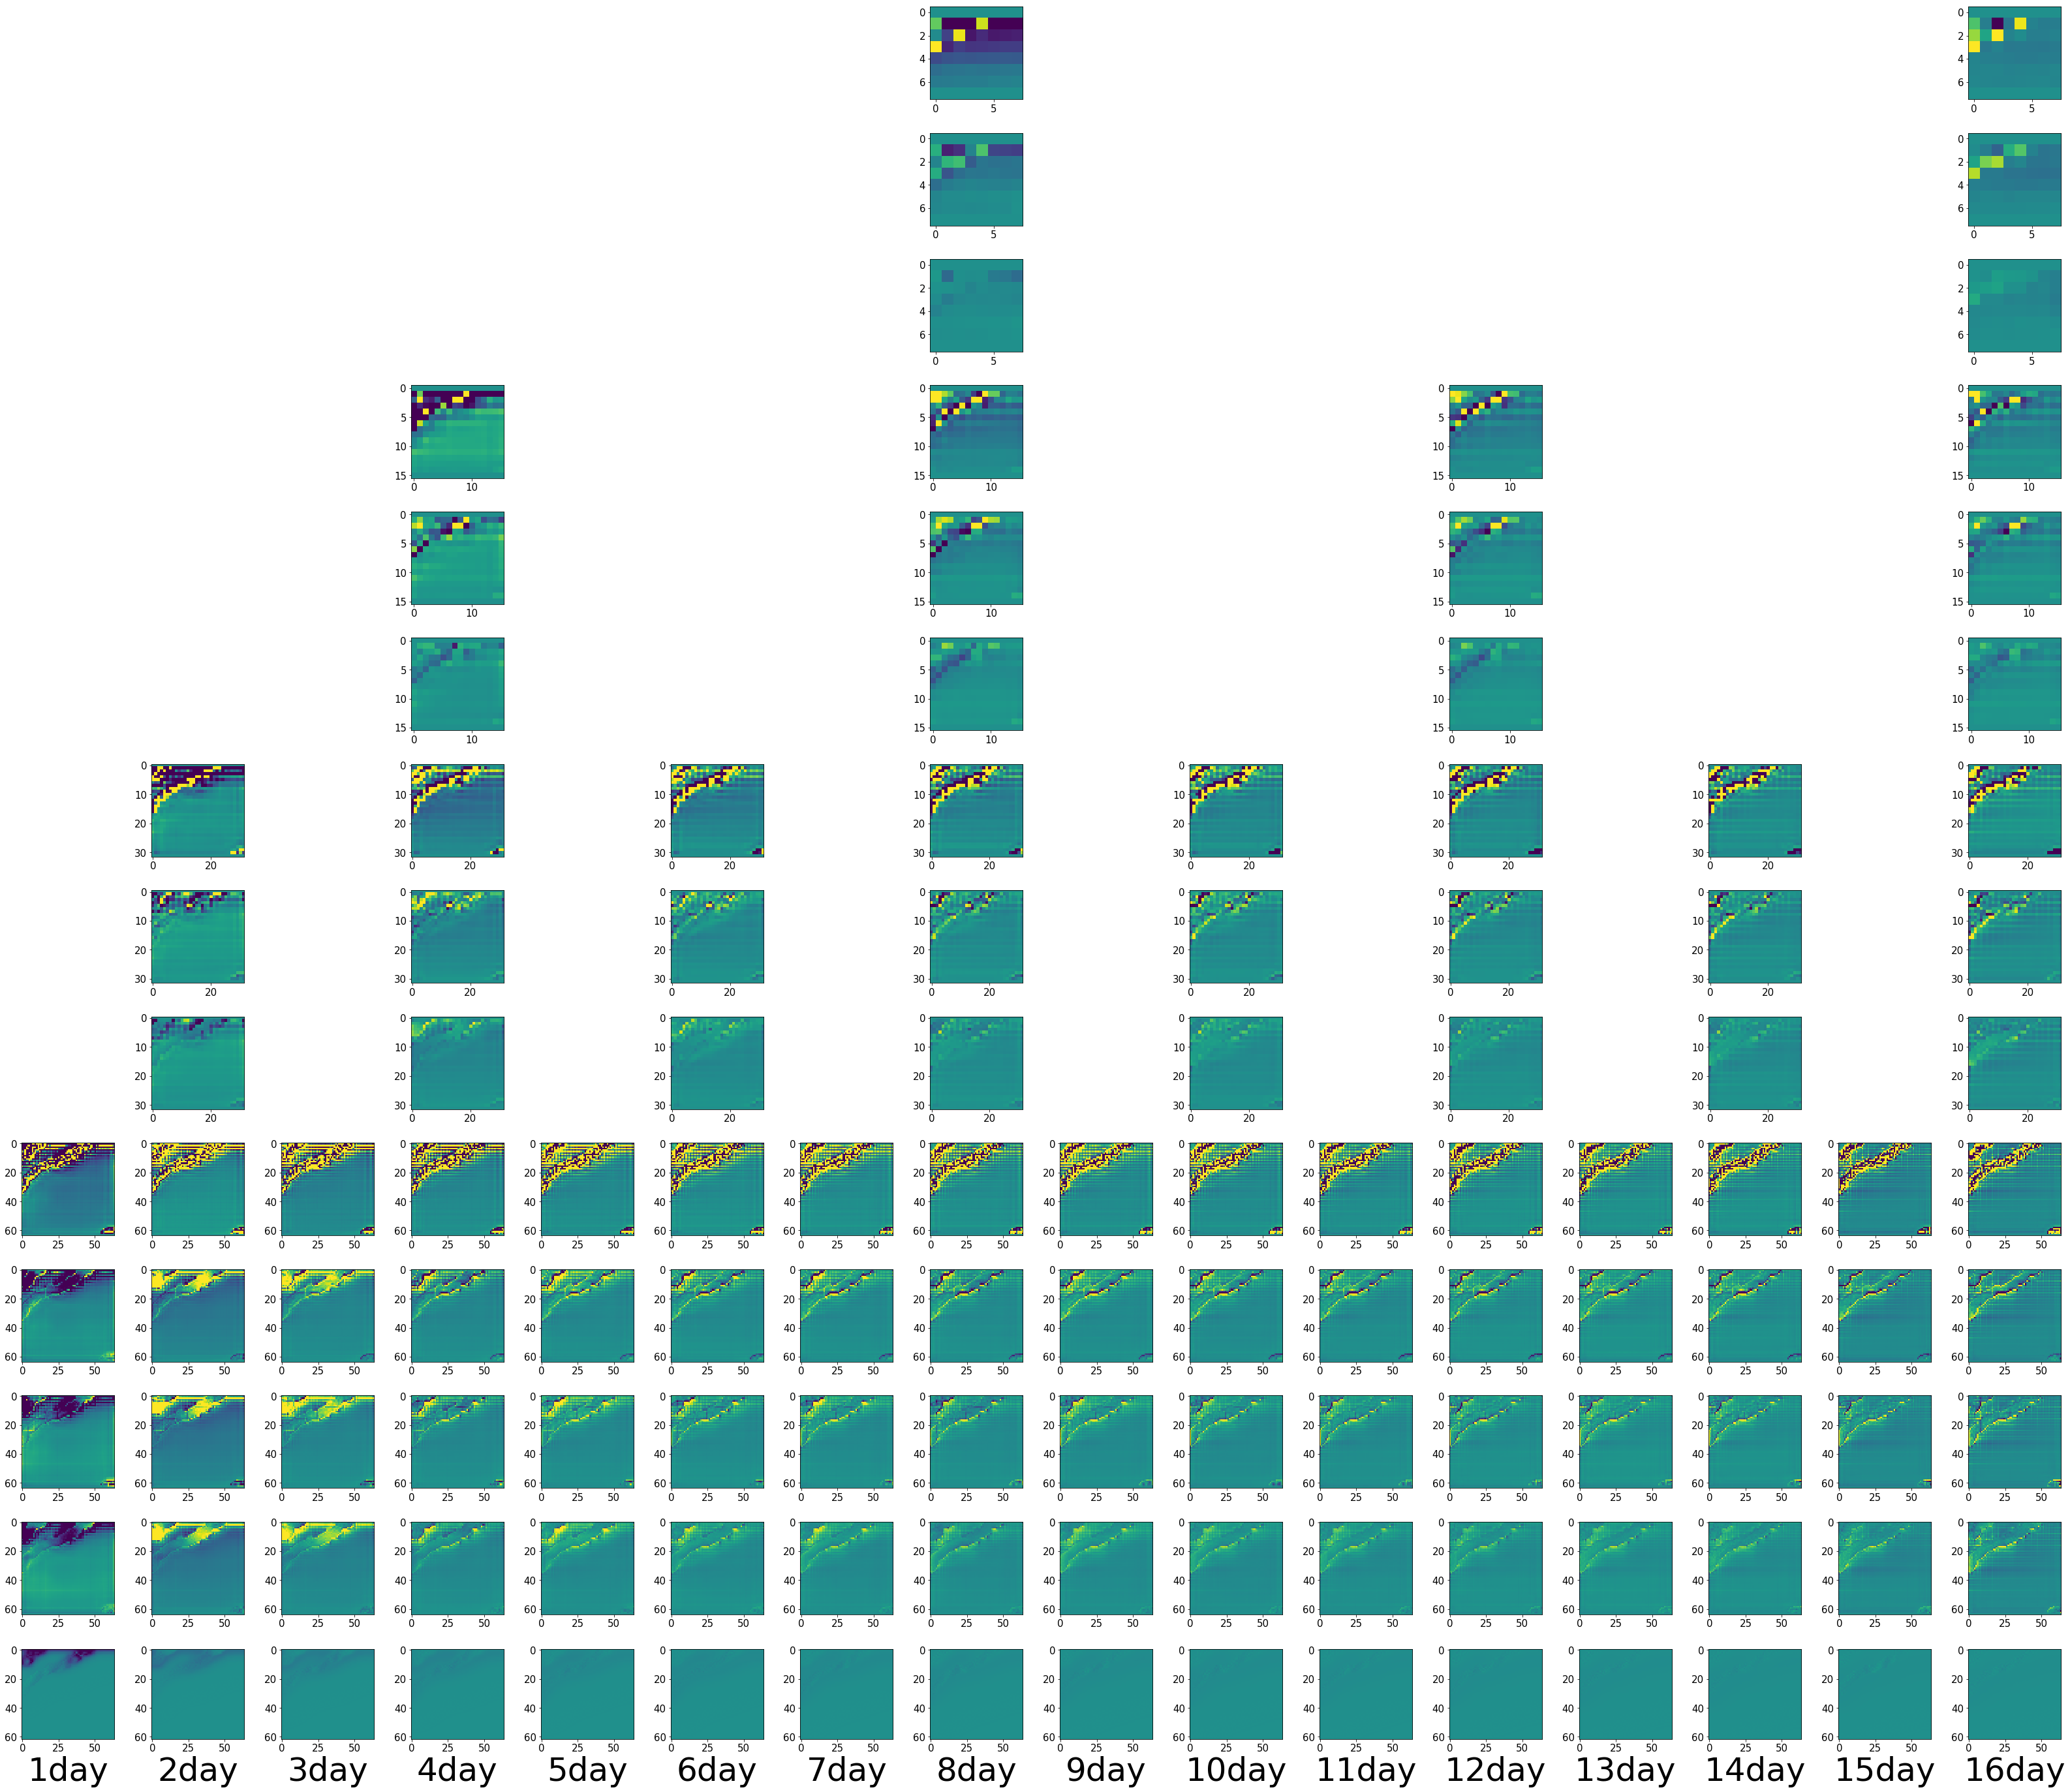

In [100]:
plt.rcParams.update({'font.size': 15})

showV_index = np.array([1, 3, 8, 9, 13, 20, 21, 25, 36, 37, 47, 57, 76])
showV_num = len(showV_index)

fig, ax = plt.subplots(showV_num + 1, 16)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(16 * 3.5, (showV_num * 1 + 1) * 3.5, forward=True)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,showV_num):
    V_cyc = showV_index[i]
    time_step = int(16 / test_pred_dict['test_pred_V' + str(V_cyc)].shape[2])
    k = -1
    
    for j in range(16):
        if (j + 1) % time_step == 0:
            k = k + 1
            ax[i, j].imshow(test_residual_dict['test_residual_V' + str(V_cyc)][ex_indx, 0, k],  vmin = -0.5, vmax = 0.5)
        else:
            ax[i, j].set_frame_on(False)
            ax[i, j].tick_params(bottom=False, left=False)
            ax[i, j].set(xticks=[], yticks=[])  # remove the tick lab

            
for i in range(16):
    ax[showV_num, i].imshow(pres_test_64_3d_residual[ex_indx, 0, i],  vmin = -0.5, vmax = 0.5)    
    ax[showV_num, i].set_xlabel(str(i+1) + 'day', fontsize=50)

In [101]:
test_residual_mean_difVcycles = np.zeros((76,))

for i in range(1, 77):
    test_residual_mean_difVcycles[i-1] = np.mean(np.abs(test_residual_dict['test_residual_V' + str(i)]))

Text(0, 0.5, 'Average of absolute residual values')

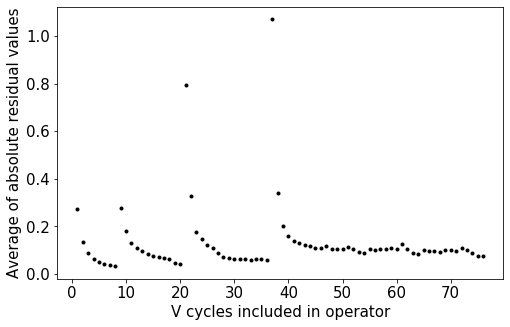

In [123]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 5, forward=True)
#plt.grid(True)
ax.plot(np.arange(1, 77), test_residual_mean_difVcycles[0:],  'k.')

ax.set_xlabel('V cycles included in operator')    
ax.set_ylabel('Average of absolute residual values')    


In [104]:
print(test_residual_mean_difVcycles[0:])

[0.27415732 0.13553719 0.09006448 0.06384626 0.0505016  0.04339498
 0.0356908  0.03152983 0.27886942 0.1784212  0.13094289 0.10973906
 0.09725529 0.08429164 0.07691753 0.07160042 0.06547031 0.0607456
 0.04758285 0.04354476 0.79300643 0.32924352 0.17673723 0.14628436
 0.12037576 0.10962375 0.08701234 0.06960089 0.06536215 0.06303607
 0.06229926 0.06084143 0.06011117 0.06192469 0.06100897 0.05834365
 1.0701202  0.33988806 0.20067696 0.15995195 0.13998826 0.12852186
 0.12221855 0.11759332 0.11035741 0.10767729 0.11844411 0.10458517
 0.10296693 0.10555876 0.11132181 0.10663286 0.09139007 0.08762797
 0.10650129 0.10197025 0.10338987 0.10544993 0.10719285 0.10653596
 0.12659421 0.1038329  0.08888386 0.08506834 0.10074416 0.09826971
 0.09687431 0.09318245 0.09895626 0.09956301 0.0965767  0.10927429
 0.09941552 0.08845511 0.07739165 0.0748717 ]


In [105]:
print(np.mean(np.abs(pres_test_64_3d_residual)))

0.013643728


In [ ]:
ex_ind = [55, 155, 355]

In [337]:
ex_indx = 347

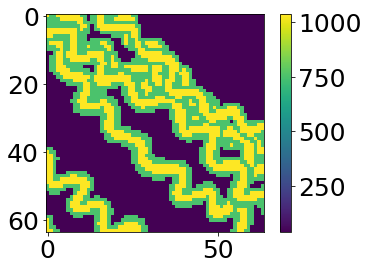

In [338]:
plt.imshow(perm_test_64[ex_indx, 0])
plt.colorbar()

Text(0, 0.5, 'Relative error')

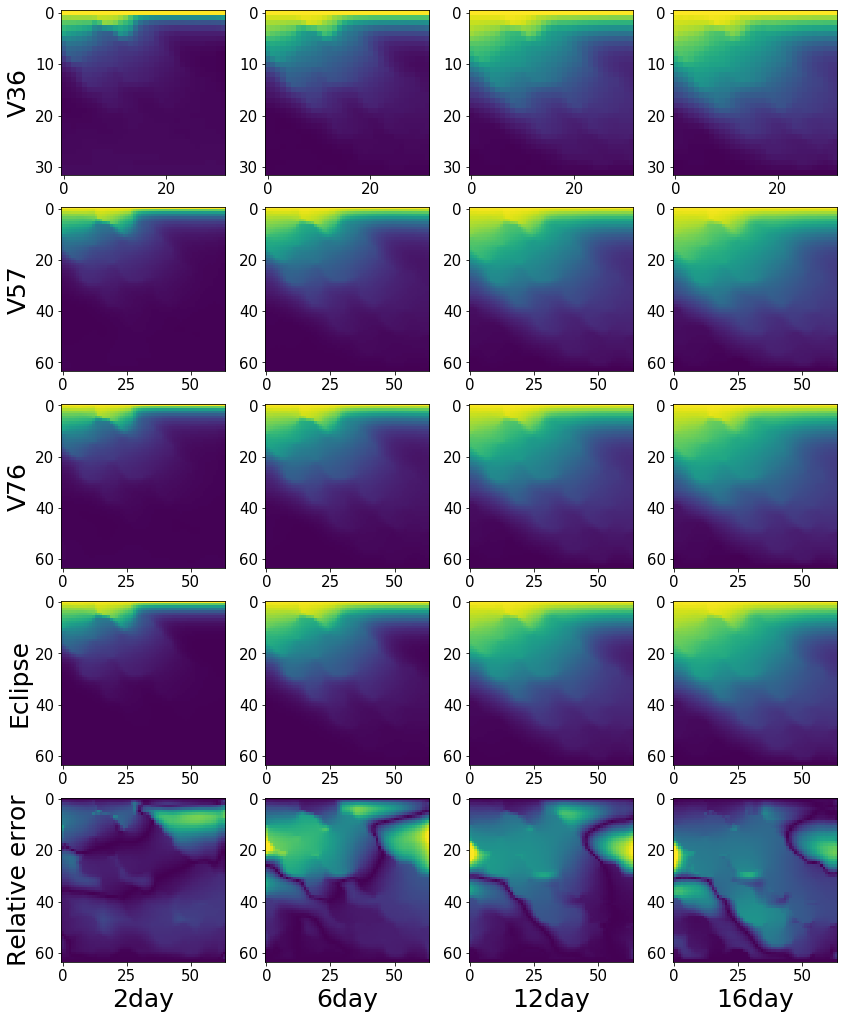

In [340]:
showV_index = [36, 57, 76]
day_ind = [2, 6, 12, 16]

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(len(showV_index) + 2, len(day_ind))   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(len(day_ind) * 3.5, (len(showV_index) + 2) * 3.5, forward=True)
# fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,len(showV_index)):
    V_cyc = showV_index[i]
    for j in range(len(day_ind)):
        if test_pred_dict['test_pred_V' + str(V_cyc)].shape[2] == 8:
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, int(day_ind[j]/2)-1])
        else: 
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, day_ind[j]-1])
    ax[i, 0].set_ylabel('V' + str(V_cyc), fontsize=25)
for j in range(len(day_ind)):
    ax[-2, j].imshow(pres_test_64[ex_indx, day_ind[j]-1])
    ax[-1, j].imshow(np.abs((test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, day_ind[j]-1] - pres_test_64[ex_indx, day_ind[j]-1]) / 200), vmax = 0.05, vmin = 0)
    ax[-1, j].set_xlabel(str(day_ind[j]) + 'day', fontsize=25)
ax[-2, 0].set_ylabel('Eclipse', fontsize=25)
ax[-1, 0].set_ylabel('Relative error', fontsize=25)

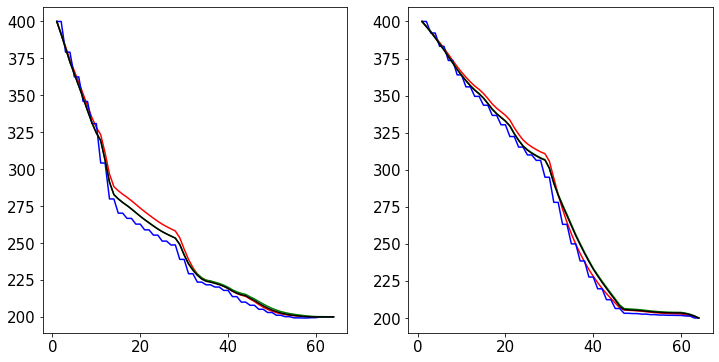

In [341]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 65), pres_test_64[ex_indx, 5, :, 25], 'r-')
ax[0].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 2, :, 12], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 5, :, 25], 'g-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 5, :, 25], 'k-')

ax[1].plot(range(1, 65), pres_test_64[ex_indx, 15, :, 9], 'r-')
ax[1].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 7, :, 4], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 15, :, 9], 'g-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 15, :, 9], 'k-')    


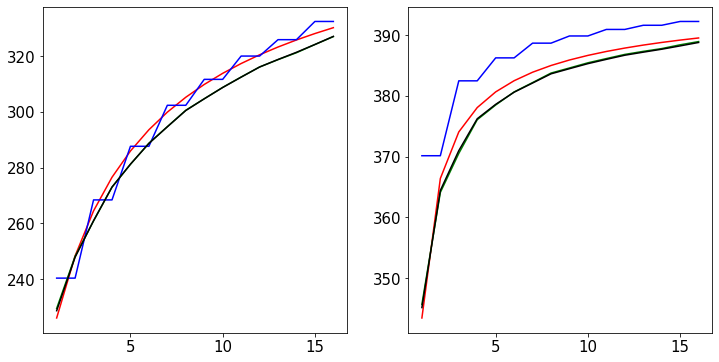

In [342]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 17), pres_test_64[ex_indx, :, 7, 33], 'r-')
ax[0].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 3, 16], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 7, 33], 'g-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 7, 33], 'k-')

ax[1].plot(range(1, 17), pres_test_64[ex_indx, :, 3, 5], 'r-')
ax[1].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 1, 2], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 3, 5], 'g-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 3, 5], 'k-')    


In [343]:
ex_indx = 615

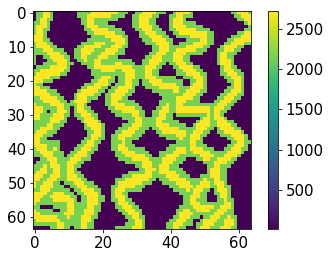

In [344]:
plt.imshow(perm_test_64[ex_indx, 0])
plt.colorbar()

Text(0, 0.5, 'Relative error')

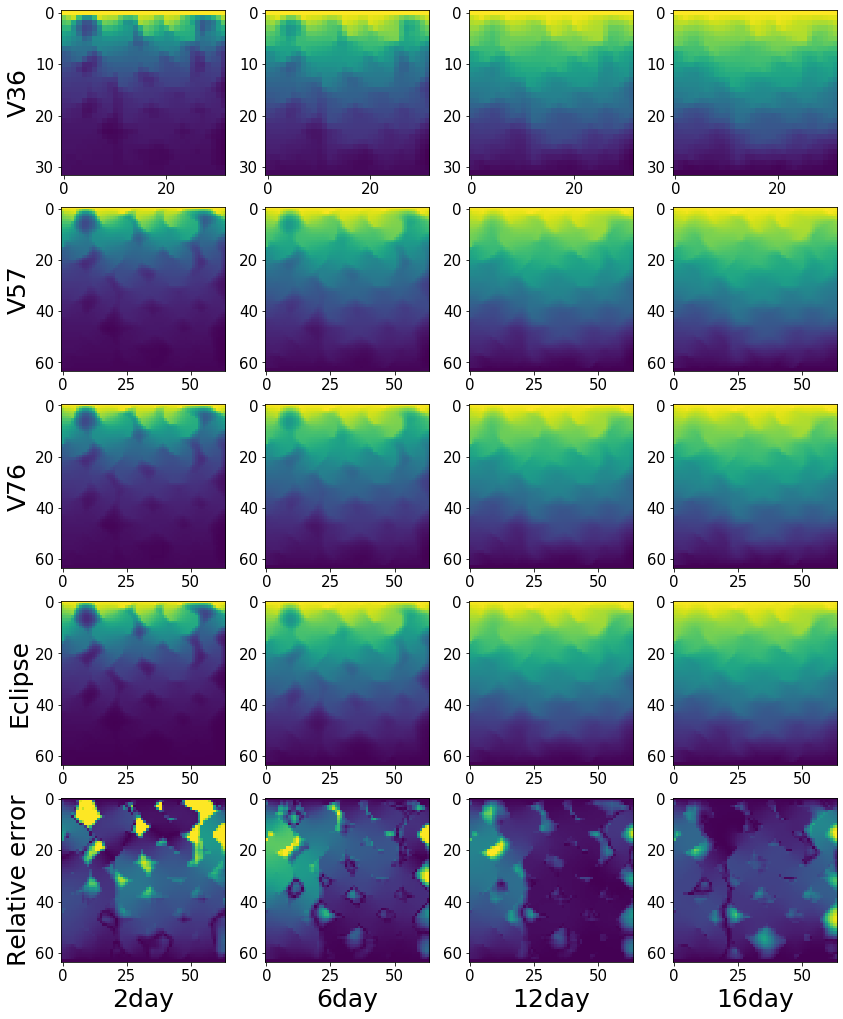

In [345]:
showV_index = [36, 57, 76]
day_ind = [2, 6, 12, 16]

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(len(showV_index) + 2, len(day_ind))   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(len(day_ind) * 3.5, (len(showV_index) + 2) * 3.5, forward=True)
# fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,len(showV_index)):
    V_cyc = showV_index[i]
    for j in range(len(day_ind)):
        if test_pred_dict['test_pred_V' + str(V_cyc)].shape[2] == 8:
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, int(day_ind[j]/2)-1])
        else: 
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, day_ind[j]-1])
    ax[i, 0].set_ylabel('V' + str(V_cyc), fontsize=25)
for j in range(len(day_ind)):
    ax[-2, j].imshow(pres_test_64[ex_indx, day_ind[j]-1])
    ax[-1, j].imshow(np.abs((test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, day_ind[j]-1] - pres_test_64[ex_indx, day_ind[j]-1]) / 200), vmax = 0.05, vmin = 0)
    ax[-1, j].set_xlabel(str(day_ind[j]) + 'day', fontsize=25)
ax[-2, 0].set_ylabel('Eclipse', fontsize=25)
ax[-1, 0].set_ylabel('Relative error', fontsize=25)

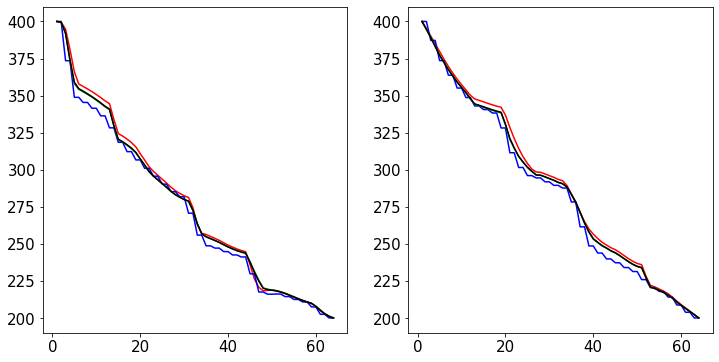

In [346]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 65), pres_test_64[ex_indx, 5, :, 25], 'r-')
ax[0].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 2, :, 12], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 5, :, 25], 'g-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 5, :, 25], 'k-')

ax[1].plot(range(1, 65), pres_test_64[ex_indx, 15, :, 9], 'r-')
ax[1].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 7, :, 4], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 15, :, 9], 'g-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 15, :, 9], 'k-')    


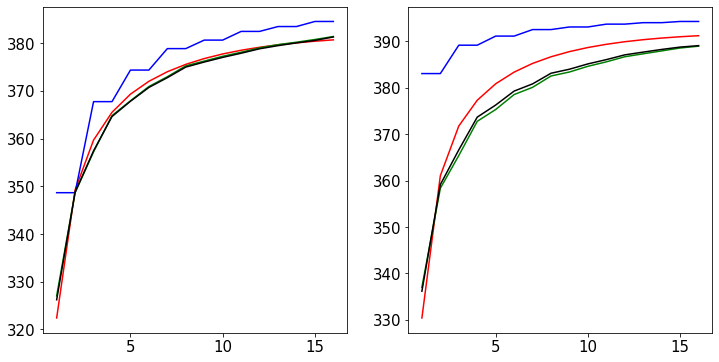

In [347]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 17), pres_test_64[ex_indx, :, 7, 33], 'r-')
ax[0].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 3, 16], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 7, 33], 'g-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 7, 33], 'k-')

ax[1].plot(range(1, 17), pres_test_64[ex_indx, :, 3, 5], 'r-')
ax[1].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 1, 2], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 3, 5], 'g-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 3, 5], 'k-')    


In [348]:
ex_indx = 618

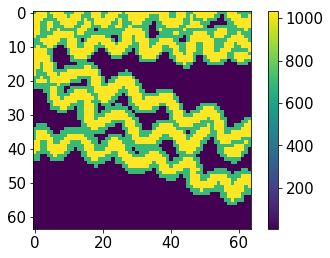

In [349]:
plt.imshow(perm_test_64[ex_indx, 0])
plt.colorbar()

Text(0, 0.5, 'Relative error')

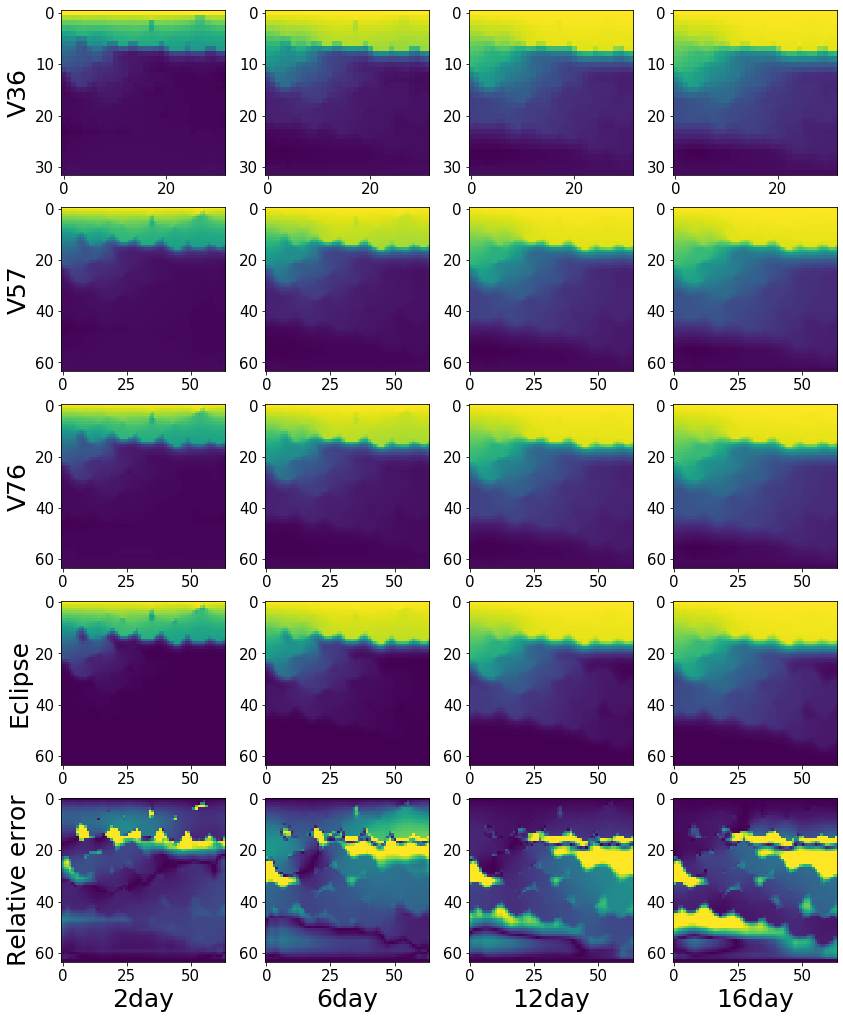

In [351]:
showV_index = [36, 57, 76]
day_ind = [2, 6, 12, 16]

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(len(showV_index) + 2, len(day_ind))   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(len(day_ind) * 3.5, (len(showV_index) + 2) * 3.5, forward=True)
# fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,len(showV_index)):
    V_cyc = showV_index[i]
    for j in range(len(day_ind)):
        if test_pred_dict['test_pred_V' + str(V_cyc)].shape[2] == 8:
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, int(day_ind[j]/2)-1])
        else: 
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, day_ind[j]-1])
    ax[i, 0].set_ylabel('V' + str(V_cyc), fontsize=25)
for j in range(len(day_ind)):
    ax[-2, j].imshow(pres_test_64[ex_indx, day_ind[j]-1])
    ax[-1, j].imshow(np.abs((test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, day_ind[j]-1] - pres_test_64[ex_indx, day_ind[j]-1]) / 200), vmax = 0.05, vmin = 0)
    ax[-1, j].set_xlabel(str(day_ind[j]) + 'day', fontsize=25)
ax[-2, 0].set_ylabel('Eclipse', fontsize=25)
ax[-1, 0].set_ylabel('Relative error', fontsize=25)

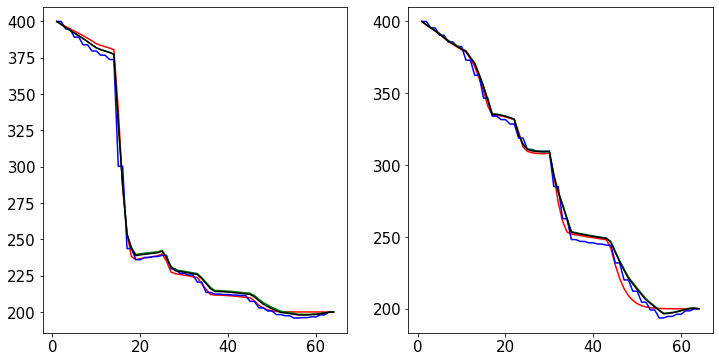

In [352]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 65), pres_test_64[ex_indx, 5, :, 25], 'r-')
ax[0].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 2, :, 12], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 5, :, 25], 'g-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 5, :, 25], 'k-')

ax[1].plot(range(1, 65), pres_test_64[ex_indx, 15, :, 9], 'r-')
ax[1].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 7, :, 4], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 15, :, 9], 'g-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 15, :, 9], 'k-')    


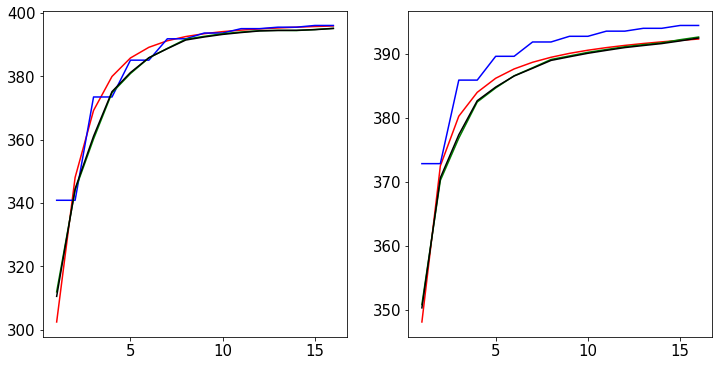

In [353]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 17), pres_test_64[ex_indx, :, 7, 33], 'r-')
ax[0].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 3, 16], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 7, 33], 'g-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 7, 33], 'k-')

ax[1].plot(range(1, 17), pres_test_64[ex_indx, :, 3, 5], 'r-')
ax[1].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 1, 2], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 3, 5], 'g-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 3, 5], 'k-')    


In [354]:
ex_indx = 626

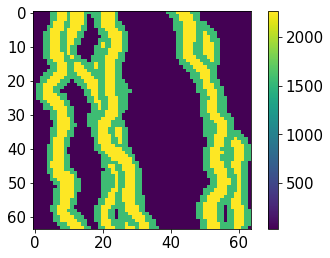

In [355]:
plt.imshow(perm_test_64[ex_indx, 0])
plt.colorbar()

Text(0, 0.5, 'Relative error')

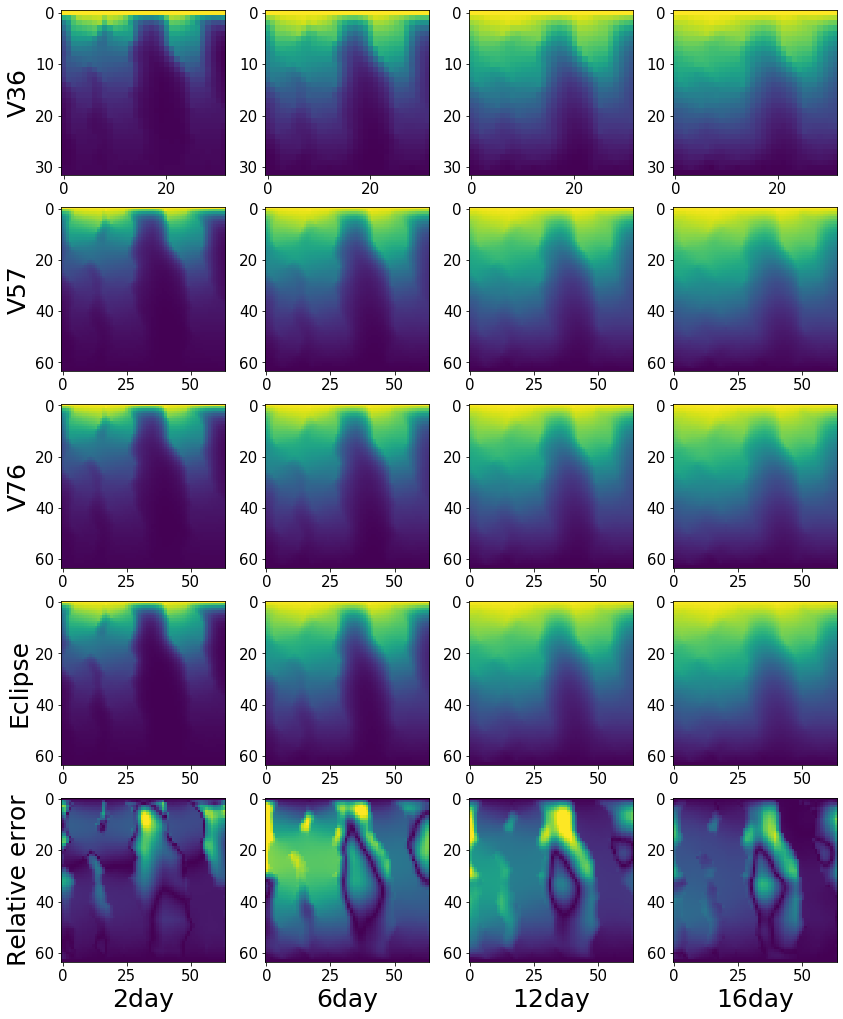

In [356]:
showV_index = [36, 57, 76]
day_ind = [2, 6, 12, 16]

plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(len(showV_index) + 2, len(day_ind))   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(len(day_ind) * 3.5, (len(showV_index) + 2) * 3.5, forward=True)
# fig.subplots_adjust(wspace=0.4, hspace=0.3)

for i in range(0,len(showV_index)):
    V_cyc = showV_index[i]
    for j in range(len(day_ind)):
        if test_pred_dict['test_pred_V' + str(V_cyc)].shape[2] == 8:
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, int(day_ind[j]/2)-1])
        else: 
            ax[i, j].imshow(test_pred_dict['test_pred_V' + str(V_cyc)][ex_indx, 0, day_ind[j]-1])
    ax[i, 0].set_ylabel('V' + str(V_cyc), fontsize=25)
for j in range(len(day_ind)):
    ax[-2, j].imshow(pres_test_64[ex_indx, day_ind[j]-1])
    ax[-1, j].imshow(np.abs((test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, day_ind[j]-1] - pres_test_64[ex_indx, day_ind[j]-1]) / 200), vmax = 0.05, vmin = 0)
    ax[-1, j].set_xlabel(str(day_ind[j]) + 'day', fontsize=25)
ax[-2, 0].set_ylabel('Eclipse', fontsize=25)
ax[-1, 0].set_ylabel('Relative error', fontsize=25)

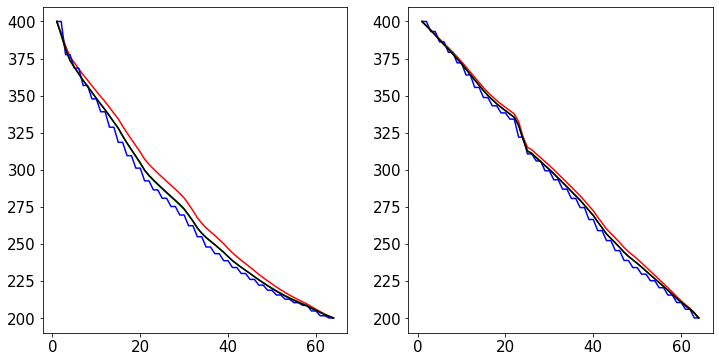

In [357]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 65), pres_test_64[ex_indx, 5, :, 25], 'r-')
ax[0].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 2, :, 12], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 5, :, 25], 'g-')
ax[0].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 5, :, 25], 'k-')

ax[1].plot(range(1, 65), pres_test_64[ex_indx, 15, :, 9], 'r-')
ax[1].plot(range(1, 65), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, 7, :, 4], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, 15, :, 9], 'g-')
ax[1].plot(range(1, 65), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, 15, :, 9], 'k-')    


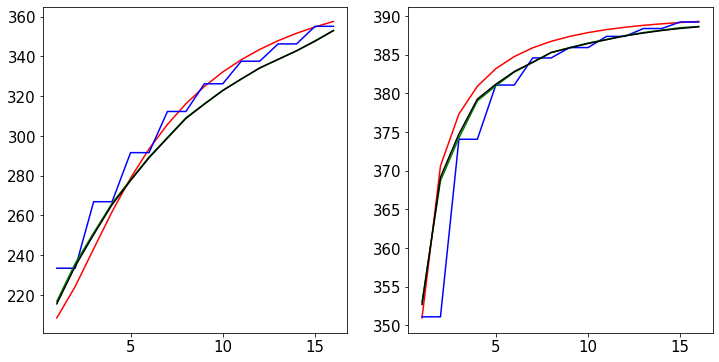

In [358]:
fig, ax = plt.subplots(1, 2)   # (int(eva_V_cycle_num) + 2, 4 * 2)
fig.set_size_inches(2*6, 1*6)

ax[0].plot(range(1, 17), pres_test_64[ex_indx, :, 7, 33], 'r-')
ax[0].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 3, 16], -1), (1, 2)).reshape(-1), 'b-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 7, 33], 'g-')
ax[0].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 7, 33], 'k-')

ax[1].plot(range(1, 17), pres_test_64[ex_indx, :, 3, 5], 'r-')
ax[1].plot(range(1, 17), np.tile(np.expand_dims(test_pred_dict['test_pred_V' + str(36)][ex_indx, 0, :, 1, 2], -1), (1, 2)).reshape(-1), 'b-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(57)][ex_indx, 0, :, 3, 5], 'g-')
ax[1].plot(range(1, 17), test_pred_dict['test_pred_V' + str(76)][ex_indx, 0, :, 3, 5], 'k-')    


In [369]:
import time

time_st = time.time()

#test_perms = test_perms
#test_pred_dict = {}
#test_residual_dict = {}
for i in range(36, 36 + 1):
    print(i)
    test_pred_dict['test_pred_V' + str(i)], test_residual_dict['test_residual_V' + str(i)] = \
    pred_with_Vcycle_pipls(i, pipls_list, compl_levels_singleV, multiV_levels, test_perms)
    
time_ed = time.time()

time_each = (time_ed - time_st) / 640

print(time_each)

36
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0

In [370]:
import time

time_st = time.time()

#test_perms = test_perms
#test_pred_dict = {}
#test_residual_dict = {}
for i in range(57, 57 + 1):
    print(i)
    test_pred_dict['test_pred_V' + str(i)], test_residual_dict['test_residual_V' + str(i)] = \
    pred_with_Vcycle_pipls(i, pipls_list, compl_levels_singleV, multiV_levels, test_perms)
    
time_ed = time.time()

time_each = (time_ed - time_st) / 640

print(time_each)

57
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0

pred for V cycle: 43
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 44
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 45
/job:localhost/replica:0/task:0/devic

In [371]:
import time

time_st = time.time()

#test_perms = test_perms
#test_pred_dict = {}
#test_residual_dict = {}
for i in range(76, 76 + 1):
    print(i)
    test_pred_dict['test_pred_V' + str(i)], test_residual_dict['test_residual_V' + str(i)] = \
    pred_with_Vcycle_pipls(i, pipls_list, compl_levels_singleV, multiV_levels, test_perms)
    
time_ed = time.time()

time_each = (time_ed - time_st) / 640

print(time_each)

76
pred for V cycle: 1
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 2
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 3
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 4
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 5
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 6
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 7
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 8
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 9
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 10
/job:localhost/replica:0/task:0

pred for V cycle: 43
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 44
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 45
/job:localhost/replica:0/task:0/devic

pred for V cycle: 62
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 63
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 64
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
pred for V cycle: 65
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/r